# 1. Загрузка данных

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import talib
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import yfinance as yf

from IPython.display import clear_output

%matplotlib inline

pd.set_option('display.max_columns', None)

In [ ]:
# Загрузим 15-минутные данные по ETH
eth_df = yf.download("ETH-USD", start='2025-01-01', end='2025-01-03', interval='15m', multi_level_index=False).drop('Adj Close', axis=1)
eth_df

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ETH-USD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (15m 2024-11-30 -> 2025-01-28) (Yahoo error = "15m data not available for startTime=1732924800 and endTime=1738022400. The requested range must be within the last 60 days.")')


,Close,High,Low,Open,Volume
Date,,,,,


In [ ]:
eth_df.to_csv('eth_15m.csv')

NameError: name 'eth_df' is not defined

In [53]:
# Загрузим из файла
eth_df = pd.read_csv('eth_data_2025_01_01_to_2025_02_19.csv', index_col=0, parse_dates=True)
eth_df 

,Close,High,Low,Open,Volume,btc_close
Datetime,,,,,,
2025-01-01 00:00:00+00:00,3337.285889,3337.397217,3330.587402,3331.279785,0,93330.968750
2025-01-01 00:15:00+00:00,3340.867188,3344.197266,3340.129639,3340.129639,203587584,93534.460938
2025-01-01 00:30:00+00:00,3352.541260,3353.072021,3341.765869,3341.765869,226148352,93711.296875
2025-01-01 00:45:00+00:00,3358.024658,3358.024658,3347.942627,3349.490234,0,94256.054688
2025-01-01 01:00:00+00:00,3354.194336,3357.458740,3349.236572,3357.458740,0,93956.867188
...,...,...,...,...,...,...
2025-02-19 22:45:00+00:00,2722.684570,2728.985596,2711.882812,2711.882812,762358784,96537.156250
2025-02-19 23:00:00+00:00,2721.705078,2729.082275,2721.705078,2723.190430,709018624,96615.671875
2025-02-19 23:15:00+00:00,2722.963623,2725.658203,2721.704834,2721.704834,1750604800,96667.070312


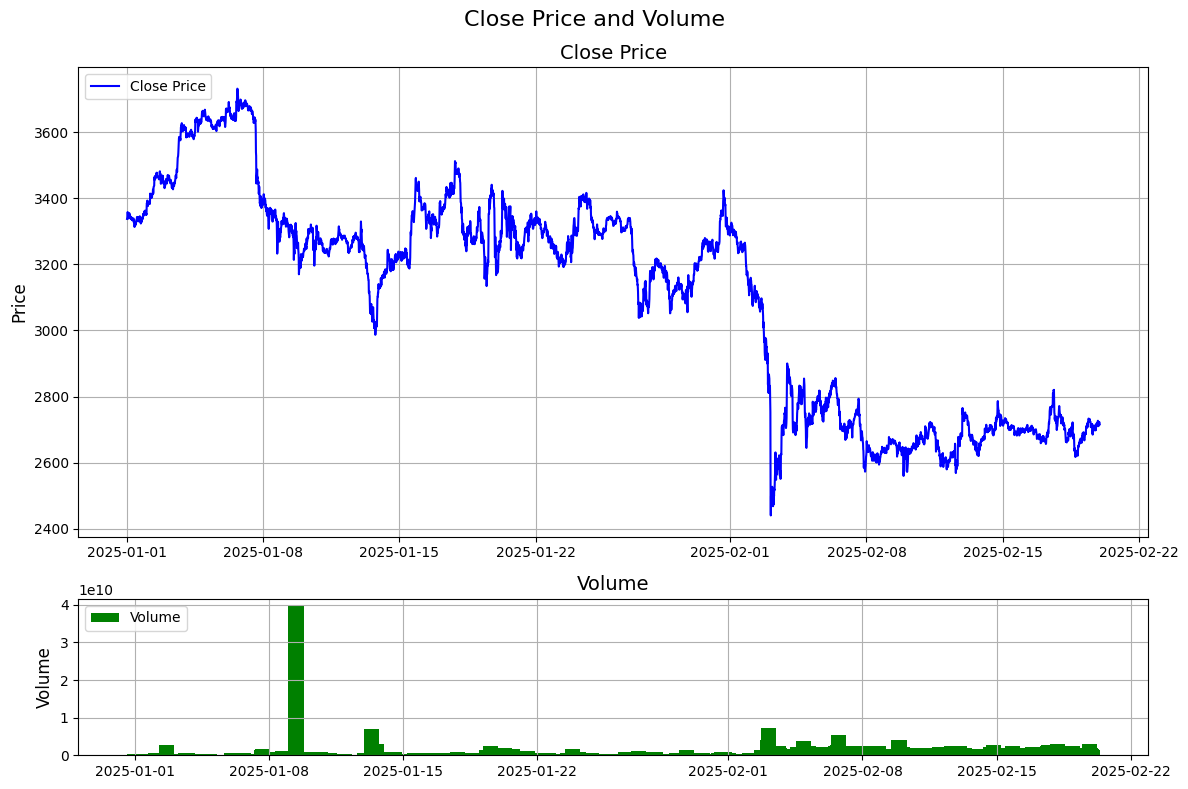

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    2, 1,  # 2 строки, 1 столбец
    figsize=(12, 8),  # Размер фигуры
    gridspec_kw={'height_ratios': [3, 1]}
)

# График Close (цена)
ax1.plot(eth_df.index, eth_df['Close'], label='Close Price', color='blue')
ax1.set_title('Close Price', fontsize=14)
ax1.set_ylabel('Price', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)

# График Volume (объем)
ax2.bar(eth_df.index, eth_df['Volume'], label='Volume', color='green')
ax2.set_title('Volume', fontsize=14)
ax2.set_ylabel('Volume', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)

# Настройка общего заголовка
plt.suptitle('Close Price and Volume', fontsize=16)

# Отображение графиков
plt.tight_layout()
plt.show()

# 2. Подготовка данных

In [5]:
def fill_missing_values(data):
    """
    Функция заполняет пропущенные значения в DataFrame предыдущими значениями 
    и удаляет дубликаты по индексу.
    """
    df = data.copy()

    # Проверка и удаление дубликатов по индексу
    if df.index.duplicated().any():
        print("Обнаружены дубликаты по индексу. Они будут удалены.")
        df = df[~df.index.duplicated(keep='first')]
    else:
        print("Дубликатов не обнаружено.")

    # Проверка на наличие пропущенных значений и нулевых значений
    if df.isnull().any().any() or (df == 0).any().any():
        print("Обнаружены пропущенные или нулевые значения. Выполняется заполнение предыдущими значениями...")

        # Заменяем нули на NaN, чтобы их можно было заполнить
        df.replace(0, np.nan, inplace=True)
        
        # Заполняем пропущенные значения предыдущими
        df = df.fillna(method='ffill')
        
        # Если в начале есть NaN, заполняем их последующими значениями
        df = df.fillna(method='bfill')
    else:
        print("Пропущенные значения отсутствуют.")

    return df

In [6]:
# Функция для добавления лагов

def add_lags(data, columns, lags):
    """Функция для добавления лагов

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета лагов
        lags (List): список шагов назад для расчета лагов
    """
    df = data.copy()

    for lag in lags: # Добавляем лаги по шагам назад из lags
        for column in columns:
            new_col_name = f'{column}_lag_{lag}'
            df[new_col_name] = df[column].shift(lag)
    
    return df

In [7]:
# Функция для добавления индикаторов

def add_indicators(data, columns, windows_SMA, windows_RSI):
    """Функция для добавления индикаторов SMA и RSI

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета индикаторов
        windows_SMA (List): список окон для расчета MA
        windows_RSI (List): список окон для расчета RSI
    """
    df = data.copy()

    for window in windows_SMA: # Расчитываем и добавляем SMA по указанным колонкам
        for column in columns:
            new_col_name = f'{column}_SMA_{window}'
            df[new_col_name] = df[column].rolling(window).mean()

    for window in windows_RSI: # Расчитываем и добавляем RSI по указанным колонкам
        for column in columns:
            new_col_name = f'{column}_RSI_{window}'
            df[new_col_name] = talib.RSI(df[column].values, timeperiod=window)
    
    return df

In [8]:
# Функция для добавления статистик

def add_stats_features(data, columns, windows):
    """Функция для добавления статистик, min, max, std за периоды windows

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета статистик
        windows (List): список окон для расчета статистик
    """   
    df = data.copy()

    for column in columns:
        for window in windows:
            # Скользящее среднее
            df[f'{column}_mean_{window}'] = df[column].rolling(window=window).mean()
            
            # Скользящая медиана
            df[f'{column}_median_{window}'] = df[column].rolling(window=window).median()
            
            # Скользящий минимум
            df[f'{column}_min_{window}'] = df[column].rolling(window=window).min()
            
            # Скользящий максимум
            df[f'{column}_max_{window}'] = df[column].rolling(window=window).max()
            
            # Скользящее стандартное отклонение
            df[f'{column}_std_{window}'] = df[column].rolling(window=window).std()
            
            # Скользящий размах (макс - мин)
            df[f'{column}_range_{window}'] = df[f'{column}_max_{window}'] - df[f'{column}_min_{window}']

    return df

In [9]:
# Функция для добавления разницы между higt и low

def add_hight_low_dif(data):
    df = data.copy()
    df['High-Low'] = df['High'] - df['Low']
    return df

In [10]:
# Функция для добавления трендовых фичей

def add_trend_feat(data, columns, windows):
    """Функция для трендовых фичей

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк трендовых фичей
        windows (List): список окон трендовых фичей
    """   
    df = data.copy()
    for column in columns:
        for window in windows:
            # Отношение текущего значения к предыдущему (лаг = 1)
            df[f'{column}_ratio_1'] = df[column] / df[column].shift(1)
            
            # Логарифмическое изменение (логарифм отношения текущего значения к предыдущему)
            df[f'{column}_log_diff_1'] = np.log(df[column] / df[column].shift(1))
            
            # Momentum (разница между текущим значением и значением N периодов назад)
            df[f'{column}_momentum_{window}'] = df[column] - df[column].shift(window)
            
            # Rate of Change (ROC): процентное изменение за N периодов
            df[f'{column}_roc_{window}'] = (df[column] - df[column].shift(window)) / df[column].shift(window) * 100
    
    return df    

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pickle

# Функция для нормализации данных

def normalize_dataframe(data, scaler="StandardScaler", save_scaler=True, scaler_file="scaler.pkl"):
    """Функция нормализует DataFrame с использованием заданного скейлера.

    Args:
    df (pd.DataFrame): Датафрейм для нормализации.
    scaler (str or sklearn Scaler): Имя скейлера ("StandardScaler", "MinMaxScaler", "RobustScaler") 
                                     или уже обученный объект скейлера.
    save_scaler (bool): сохранять ли scaler в файл (по умолчанию: сохранять)
    scaler_file (str): Имя файла, куда сохраняется обученный скейлер (по умолчанию: "scaler.pkl").

    """
    df = data.copy()

    if isinstance(scaler, str):
        # Создаем скейлер на основе переданного имени
        if scaler == "StandardScaler":
            scaler = StandardScaler()
        elif scaler == "MinMaxScaler":
            scaler = MinMaxScaler()
        elif scaler == "RobustScaler":
            scaler = RobustScaler()
        else:
            raise ValueError(f"Неизвестный скейлер: {scaler}")

        # Обучаем скейлер на датафрейме
        scaler.fit(df)

        # Сохраняем обученный скейлер в файл
        if save_scaler:
            with open(scaler_file, "wb") as f:
                pickle.dump(scaler, f)
    elif hasattr(scaler, "transform"):
        # Если передан обученный скейлер, просто используем его
        pass
    else:
        raise ValueError("Передан некорректный скейлер. Должна быть строка 'StandardScaler', 'MinMaxScaler', 'RobustScaler' или объект sklearn Scaler.")

    # Применяем скейлер к датафрейму
    normalized_data = scaler.transform(df)

    # Возвращаем нормализованный датафрейм и обученный скейлер
    return pd.DataFrame(normalized_data, columns=df.columns, index=df.index), scaler

In [12]:
# Функция для загрузки скейлера из файла
def load_scaler(scaler_file):
    """Загружает скейлер из указанного файла.

    Args:
    scaler_file (str): Путь к файлу, содержащему сохранённый скейлер.

    Return:
    sklearn Scaler: Загруженный объект скейлера.
    """
    with open(scaler_file, "rb") as f:
        scaler = pickle.load(f)
    return scaler

In [13]:
# Функция для добавления номеров месяцев, дней, часов

def add_datetime_features(data, add_month=True, add_weekday=True, add_hour=True):
    """Функция добавляет в DataFrame столбцы с номером месяца, дня недели и часа из индекса Datetime.
    
    Args:
    df (pd.DataFrame): DataFrame с индексом типа Datetime.
    add_month (bool): Добавлять ли столбец с номером месяца (1-12).
    add_weekday (bool): Добавлять ли столбец с номером дня недели (0 - понедельник, 6 - воскресенье).
    add_hour (bool): Добавлять ли столбец с номером часа (0-23).
    """
    df = data.copy()
    
    # Добавляем столбцы по выбору
    if add_month:
        df['Month'] = df.index.month
    if add_weekday:
        df['Weekday'] = df.index.weekday
    if add_hour:
        df['Hour'] = df.index.hour
    
    return df

In [54]:
def prepare_date(data, 
                 lags, 
                 windows_SMA, 
                 windows_RSI, 
                 windows_stats, 
                 windows_trend, 
                 add_month=True, 
                 add_weekday=True, 
                 add_hour=True):
    """
    Функция для добавления фичей и нормализации

    Args:
        data (pd.DataFrame): DataFrame с индексом типа Datetime.
        windows_SMA (List): список окон для индикатора SMA.
        windows_RSI (List): список окон для индикатора RSI.
        windows_stats (List): список окон для статистических фичей.
        windows_trend (List): список окон для трендовых фичей.
        add_month (bool): Добавлять ли столбец с номером месяца (1-12).
        add_weekday (bool): Добавлять ли столбец с номером дня недели (0 - понедельник, 6 - воскресенье).
        add_hour (bool): Добавлять ли столбец с номером часа (0-23).
    """

    df = data.copy()
    columns = df.columns

    df = fill_missing_values(df)
    df = add_lags(df, columns=columns, lags=lags)
    df = add_indicators(df, columns=['Close'], windows_SMA=windows_SMA, windows_RSI=windows_RSI)
    df = add_stats_features(df, columns=['Close', 'btc_close'], windows=windows_stats)
    df = add_hight_low_dif(df)
    df = add_trend_feat(df, columns=['Close', 'btc_close'], windows=windows_trend)
    df = add_datetime_features(df, add_month=add_month, add_weekday=add_weekday, add_hour=add_hour)
    df = df.dropna()

    return df

In [55]:
eth_df.describe()

,Close,High,Low,Open,Volume,btc_close
count,4793.000000,4793.000000,4793.000000,4793.000000,4.793000e+03,4793.000000
mean,3105.852702,3111.777687,3099.730503,3105.873248,3.600372e+08,98957.213325
std,324.334380,323.974483,324.695623,324.282645,7.586959e+08,3769.693119
min,2440.854492,2475.266602,2196.839600,2451.004395,0.000000e+00,90396.179688
25%,2722.056152,2727.046875,2717.524414,2721.784668,1.536205e+07,96196.289062
50%,3228.159180,3233.700195,3221.138916,3228.282959,1.586309e+08,97819.164062
75%,3331.842529,3336.928223,3326.113770,3331.485107,5.185659e+08,102190.984375
max,3731.067139,3742.588135,3727.289307,3732.922119,3.963021e+10,108837.968750


In [16]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4793 entries, 2025-01-01 00:00:00+00:00 to 2025-02-19 23:45:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      4793 non-null   float64
 1   High       4793 non-null   float64
 2   Low        4793 non-null   float64
 3   Open       4793 non-null   float64
 4   Volume     4793 non-null   int64  
 5   btc_close  4793 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 262.1 KB


In [56]:
window_lag = [3, 9, 15, 30]
window_SMA = [6, 9, 30, 50]
window_RSI = [4, 9, 20]
windows_stats = [3, 10, 30, 50]
windows_trend = [3, 10, 30, 50]

In [57]:
eth_df_features = prepare_date(eth_df, lags=window_lag, windows_SMA=window_SMA, windows_RSI=window_RSI, windows_stats=windows_stats, windows_trend=windows_trend)

Дубликатов не обнаружено.
Обнаружены пропущенные или нулевые значения. Выполняется заполнение предыдущими значениями...


C:\Users\Vit\AppData\Local\Temp\ipykernel_9956\176028078.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
C:\Users\Vit\AppData\Local\Temp\ipykernel_9956\176028078.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


In [58]:
eth_df_features.shape

(4743, 109)

Идея: Попробовать обучить модель предсказывать сильные движения цены. Целевая метка - изменение цены через час. Будем отслеживать рост или снижение цены более чем заданное процентное изменение.

In [60]:
def add_target_column(df, close_col='Close', threshold=1):
    """
    Добавляет колонку target в датафрейм на основе процентного изменения цены через час.

    - df: Исходный датафрейм.
    - close_col: Название колонки с ценами закрытия.
    - threshold: Пороговое значение процента для классификации.
    """
    # Рассчитываем процентное изменение цены через час
    df['price_change_pct'] = df[close_col].pct_change(periods=4).shift(-4) * 100

    # Создаем колонку target на основе условий
    df['target'] = np.select(
        [
            df['price_change_pct'] < -threshold,  # Цена упала на threshold и больше
            (df['price_change_pct'] >= -threshold) & (df['price_change_pct'] <= threshold),  # Цена в пределах threshold
            df['price_change_pct'] > threshold  # Цена выросла на threshold и больше
        ],
        [0, 1, 2],  # Соответствующие классы
        default=np.nan  # Если значение NaN (последние 4 строки)
    )

    # Удаляем временную колонку price_change_pct
    df.drop(columns=['price_change_pct'], inplace=True)

    # Удаляем строки с NaN в target (последние 4 строки)
    df.dropna(subset=['target'], inplace=True)

    # Преобразуем target в целые числа
    df['target'] = df['target'].astype(int)

    return df

# 3. Добавляем Target

In [61]:
eth_df_features = add_target_column(eth_df_features, threshold=0.2)

eth_df_features

,Close,High,Low,Open,Volume,btc_close,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,btc_close_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,btc_close_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,btc_close_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,btc_close_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,btc_close_mean_3,btc_close_median_3,btc_close_min_3,btc_close_max_3,btc_close_std_3,btc_close_range_3,btc_close_mean_10,btc_close_median_10,btc_close_min_10,btc_close_max_10,btc_close_std_10,btc_close_range_10,btc_close_mean_30,btc_close_median_30,btc_close_min_30,btc_close_max_30,btc_close_std_30,btc_close_range_30,btc_close_mean_50,btc_close_median_50,btc_close_min_50,btc_close_max_50,btc_close_std_50,btc_close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,btc_close_ratio_1,btc_close_log_diff_1,btc_close_momentum_3,btc_close_roc_3,btc_close_momentum_10,btc_close_roc_10,btc_close_momentum_30,btc_close_roc_30,btc_close_momentum_50,btc_close_roc_50,Month,Weekday,Hour,target
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-01 12:30:00+00:00,3343.072754,3344.783691,3341.038330,3343.430420,4.343808e+07,93679.632812,3334.746826,3339.170166,3334.012695,3337.341064,4.343808e+07,93267.125000,3325.237549,3328.333740,3323.114502,3323.114502,9.007104e+06,93254.468750,3330.404053,3333.293213,3328.243164,3331.517090,5076992.0,93259.992188,3339.198975,3339.198975,3334.000000,3334.000000,1.054720e+06,93447.375000,3336.257935,3331.594265,3332.004256,3337.854551,87.426735,68.418219,57.020899,3340.554118,3343.072754,3335.316406,3343.273193,4.537098,7.956787,3330.958594,3330.569214,3319.422119,3343.273193,8.375223,23.851074,3332.004256,3334.248535,3312.978760,3343.273193,7.791334,30.294434,3337.854551,3338.296997,3312.978760,3358.024658,10.136359,45.045898,93513.197917,93616.367188,93243.593750,93679.632812,235.617147,436.039062,93304.431250,93258.507812,93111.765625,93679.632812,195.346178,567.867188,93349.735156,93330.218750,92867.187500,93679.632812,214.242752,812.445312,93471.558125,93515.777344,92867.187500,94256.054688,255.901936,1388.867188,3.745361,0.999940,-0.000060,8.325928,0.249672,17.716309,0.532764,3.873779,0.116009,5.786865,0.173400,1.000676,0.000676,412.507812,0.442286,442.554688,0.474655,232.257812,0.248544,348.664062,0.373578,1,2,12,0
2025-01-01 12:45:00+00:00,3340.229736,3340.972900,3338.161133,3340.972900,4.343808e+07,93618.367188,3335.316406,3335.985107,3333.931885,3334.479492,4.343808e+07,93243.593750,3324.588379,3329.039795,3323.121826,3325.411865,9.007104e+06,93138.328125,3325.482666,3333.349854,3325.310059,3330.390137,191223808.0,93106.484375,3342.497070,3342.497070,3338.213135,3338.907959,9.932800e+06,93582.289062,3338.470459,3333.332194,3331.928678,3337.841802,67.214291,62.324199,54.907598,3342.191895,3343.072754,3340.229736,3343.273193,1.702232,3.043457,3332.457812,3334.465332,3319.422119,3343.273193,8.576754,23.851074,3331.928678,3334.248535,3312.978760,3343.273193,7.696461,30.294434,3337.841802,3338.296997,3312.978760,3358.024658,10.132893,45.045898,93638.122396,93618.367188,93616.367188,93679.632812,35.962981,63.265625,93340.821094,93264.835938,93111.765625,93679.632812,217.628245,567.867188,93350.937760,93330.218750,92867.187500,93679.632812,215.689528,812.445312,93473.236250,93515.777344,92867.187500,94256.054688,256.597023,1388.867188,2.811768,0.999150,-0.000851,4.91333

In [62]:
print("Количество каждого класса:")
print(eth_df_features['target'].value_counts())

Количество каждого класса:
target
0    1666
2    1654
1    1419
Name: count, dtype: int64


Классы не сбалансированы.

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=eth_df_features.index,
    y=eth_df_features['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='blue')
))

# Подкрашиваем точки, где target == 2 (зеленым)
fig.add_trace(go.Scatter(
    x=eth_df_features[eth_df_features['target'] == 2].index,
    y=eth_df_features[eth_df_features['target'] == 2]['Close'],
    mode='markers',
    name='Target 2 (Цена вырастет в через час ≥ 2%)',
    marker=dict(color='green', size=10)
))

# Подкрашиваем точки, где target == 0 (красным)
fig.add_trace(go.Scatter(
    x=eth_df_features[eth_df_features['target'] == 0].index,
    y=eth_df_features[eth_df_features['target'] == 0]['Close'],
    mode='markers',
    name='Target 0 (Цена упадет через час≥ 2%)',
    marker=dict(color='red', size=10)
))

fig.update_layout(
    title='Close Price with Target',
    xaxis_title='Time',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white'
)

fig.show()

In [63]:
val_size = 400  # Размер валидационной выборки
test_size = 400  # Размер тестовой выборки

# Валидационная выборка
val_df = eth_df_features.iloc[-(val_size + test_size):-test_size]

# Тестовая выборка
test_df = eth_df_features.iloc[-test_size:]

# Обучающая выборка (все остальные данные)
train_df = eth_df_features.iloc[:-(val_size + test_size)]

# Проверка размеров выборок
print(f"Размер обучающей выборки (train): {len(train_df)}")
print(f"Размер валидационной выборки (val): {len(val_df)}")
print(f"Размер тестовой выборки (test): {len(test_df)}")

print("Количество каждого класса в обучающей выборке:")
print(train_df['target'].value_counts())

print("Количество каждого класса в валидационной выборке:")
print(val_df['target'].value_counts())

print("Количество каждого класса в тестовой выборке:")
print(test_df['target'].value_counts())

Размер обучающей выборки (train): 3939
Размер валидационной выборки (val): 400
Размер тестовой выборки (test): 400
Количество каждого класса в обучающей выборке:
target
0    1399
2    1369
1    1171
Name: count, dtype: int64
Количество каждого класса в валидационной выборке:
target
2    134
1    134
0    132
Name: count, dtype: int64
Количество каждого класса в тестовой выборке:
target
2    151
0    135
1    114
Name: count, dtype: int64


In [64]:
# Разделяем train_df
X_train = train_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_train = train_df.iloc[:, -1]   # Последний столбец (target)

# Разделяем val_df
X_val = val_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_val = val_df.iloc[:, -1]   # Последний столбец (target)

# Разделяем test_df
X_test = test_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_test = test_df.iloc[:, -1]   # Последний столбец (target)

# Проверка размеров
print(f"Размеры train: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Размеры val: X_val = {X_val.shape}, y_val = {y_val.shape}")
print(f"Размеры test: X_test = {X_test.shape}, y_test = {y_test.shape}")

# Вывод первых строк X_train и y_train
print("\nX_train:")
print(X_train.head())

print("\ny_train:")
print(y_train.head())

Размеры train: X_train = (3939, 109), y_train = (3939,)
Размеры val: X_val = (400, 109), y_val = (400,)
Размеры test: X_test = (400, 109), y_test = (400,)

X_train:
                                 Close         High          Low         Open  \
Datetime                                                                        
2025-01-01 12:30:00+00:00  3343.072754  3344.783691  3341.038330  3343.430420   
2025-01-01 12:45:00+00:00  3340.229736  3340.972900  3338.161133  3340.972900   
2025-01-01 13:00:00+00:00  3332.834473  3344.976318  3332.834473  3340.183594   
2025-01-01 13:15:00+00:00  3331.148926  3334.383545  3327.366943  3331.708984   
2025-01-01 13:30:00+00:00  3330.831055  3335.455566  3330.733887  3331.089355   

                               Volume     btc_close  Close_lag_3   High_lag_3  \
Datetime                                                                        
2025-01-01 12:30:00+00:00  43438080.0  93679.632812  3334.746826  3339.170166   
2025-01-01 12:45:00+00:0

In [65]:
# нормализация X
X_train_scaled, scaler = normalize_dataframe(X_train, scaler='StandardScaler')

# Применение того же scaler к валидационной и тестовой выборкам
X_val_scaled, _ = normalize_dataframe(X_val, scaler=scaler, save_scaler=False)
X_test_scaled, _ = normalize_dataframe(X_test, scaler=scaler, save_scaler=False)

In [66]:
X_train_scaled.head()

,Close,High,Low,Open,Volume,btc_close,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,btc_close_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,btc_close_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,btc_close_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,btc_close_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,btc_close_mean_3,btc_close_median_3,btc_close_min_3,btc_close_max_3,btc_close_std_3,btc_close_range_3,btc_close_mean_10,btc_close_median_10,btc_close_min_10,btc_close_max_10,btc_close_std_10,btc_close_range_10,btc_close_mean_30,btc_close_median_30,btc_close_min_30,btc_close_max_30,btc_close_std_30,btc_close_range_30,btc_close_mean_50,btc_close_median_50,btc_close_min_50,btc_close_max_50,btc_close_std_50,btc_close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,btc_close_ratio_1,btc_close_log_diff_1,btc_close_momentum_3,btc_close_roc_3,btc_close_momentum_10,btc_close_roc_10,btc_close_momentum_30,btc_close_roc_30,btc_close_momentum_50,btc_close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-01 12:30:00+00:00,0.532767,0.518853,0.546173,0.534026,-0.393641,-1.502867,0.502945,0.498298,0.520915,0.511902,-0.392766,-1.606794,0.467833,0.458491,0.481163,0.460527,-0.435602,-1.605559,0.483357,0.473337,0.496507,0.487226,-0.439299,-1.599160,0.507958,0.487972,0.510497,0.489919,-0.441844,-1.540143,0.508884,0.492504,0.491916,0.510503,1.735261,1.240824,0.695816,0.523961,0.532228,0.529575,0.509614,-0.415927,-0.467322,0.490209,0.487867,0.517479,0.466428,-0.449967,-0.527067,0.491916,0.497289,0.56855,0.389662,-0.845836,-0.937928,0.510503,0.508087,0.616903,0.385634,-0.875688,-0.944031,-1.546856,-1.519911,-1.578883,-1.538876,0.416717,0.368290,-1.603209,-1.613248,-1.545516,-1.600084,-0.393729,-0.443327,-1.597905,-1.599389,-1.490562,-1.690686,-0.732265,-0.796564,-1.572948,-1.555823,-1.40488,-1.611641,-0.832840,-0.713720,-0.737505,-0.002773,-0.000584,0.374284,0.339690,0.446189,0.407662,0.111204,0.096794,0.141725,0.124321,0.235342,0.236713,0.809867,0.867913,0.481500,0.512481,0.126360,0.128035,0.150024,0.151558,-0.59113,-0.51266,0.072317
2025-01-01 12:45:00+00:00,0.522991,0.505704,0.536313,0.525572,-0.393641,-1.518599,0.504906,0.487295,0.520638,0.502047,-0.392766,-1.612832,0.465593,0.460935,0.481188,0.468457,-0.435602,-1.635305,0.466342,0.473533,0.486400,0.483328,-0.201019,-1.638400,0.519417,0.499472,0.525083,0.506977,-0.430470,-1.505802,0.516507,0.498499,0.491653,0.510458,0.802140,0.835072,0.495432,0.529597,0.532228,0.546421,0.509614,-0.783226,-0.801493,0.495383,0.501309,0.517479,0.466428,-0.433322,-0.527067,0.491653,0.497289,0.56855,0.389662,-0.850591,-0.937928,0.510458,0.508087,0.616903,0.385634,-0.875825,-0.944031,-1.514747,-1.519397,-1.482836,-1.538876,-0.789530,-0.805274,-1.593835,-1.611620,-1.545516,-1.600084,-0.304754,-0.443327,-1.597594,-1.599389,-1.490562,-1.690686,-0.728643,-0.796564,-1.572511,-1.555823,-1.40488,-1.611641,-0.831428,-0.713720,-0.814074,-0.185025,-0.181830,0.229818,0.207920,0.383518,0.349967,0.033053,0.024217,0.076473,0.063478,-0.236815,-0.235526,0.735280,0.787959,0.393876,0.418372,0.001110,-0.006117,0.014036,0.005949,-0.59113,-0.51266,0.072317
2025-01-01 13:00:00+00:00,0.497562,0.519517,0.518058,0.522857,-0.415990,-1.555807,0.532297,0.512471,0.525898,0.505441,-0.392766,-1.517189,0.447768,0.445354,0.468466,0.464218,-0.252421,-1.642108,0.423110,0.453276,0.437732,0

In [67]:
X_val_scaled.head()

,Close,High,Low,Open,Volume,btc_close,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,btc_close_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,btc_close_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,btc_close_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,btc_close_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,btc_close_mean_3,btc_close_median_3,btc_close_min_3,btc_close_max_3,btc_close_std_3,btc_close_range_3,btc_close_mean_10,btc_close_median_10,btc_close_min_10,btc_close_max_10,btc_close_std_10,btc_close_range_10,btc_close_mean_30,btc_close_median_30,btc_close_min_30,btc_close_max_30,btc_close_std_30,btc_close_range_30,btc_close_mean_50,btc_close_median_50,btc_close_min_50,btc_close_max_50,btc_close_std_50,btc_close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,btc_close_ratio_1,btc_close_log_diff_1,btc_close_momentum_3,btc_close_roc_3,btc_close_momentum_10,btc_close_roc_10,btc_close_momentum_30,btc_close_roc_30,btc_close_momentum_50,btc_close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-11 15:00:00+00:00,-1.829574,-1.792910,-1.819091,-1.798252,-0.435144,-0.666904,-1.831398,-1.859230,-1.823781,-1.853222,0.968039,-0.653654,-1.729612,-1.743635,-1.701526,-1.726842,-0.198759,-0.434325,-1.686267,-1.713871,-1.685441,-1.713641,-0.175466,-0.361302,-1.650310,-1.671786,-1.637072,-1.648492,0.295497,-0.268048,-1.842787,-1.815991,-1.736400,-1.745121,-0.441039,-0.794580,-0.916895,-1.815426,-1.818963,-1.799321,-1.826725,-0.305895,-0.287907,-1.807987,-1.814718,-1.822657,-1.796744,0.332401,0.533706,-1.736400,-1.716119,-1.733425,-1.805131,-0.106566,-0.015368,-1.745121,-1.735253,-1.674888,-1.873246,-0.455540,-0.379182,-0.644808,-0.650918,-0.627714,-0.654449,-0.392786,-0.377931,-0.586971,-0.633794,-0.565822,-0.544138,0.324981,0.067918,-0.444681,-0.396994,-0.441437,-0.526672,-0.096623,-0.317856,-0.416470,-0.391077,-0.34901,-0.56491,-0.461403,-0.602779,0.915701,-0.904985,-0.899221,-0.003531,-0.010738,-0.711951,-0.822358,-0.726442,-0.848769,-0.128034,-0.175782,-0.237705,-0.236417,-0.097999,-0.103906,-0.920804,-0.947247,-0.985853,-1.010519,-0.402583,-0.422010,1.691675,-1.009918,0.505891
2025-02-11 15:15:00+00:00,-1.835065,-1.819581,-1.806793,-1.814336,0.328185,-0.657075,-1.821037,-1.849031,-1.815833,-1.831712,0.694312,-0.614599,-1.713482,-1.741074,-1.707263,-1.730519,0.724396,-0.435236,-1.694105,-1.707685,-1.666014,-1.688128,1.080293,-0.384499,-1.668654,-1.681235,-1.642450,-1.654247,0.722012,-0.303031,-1.830887,-1.830780,-1.743153,-1.747056,-0.536378,-0.848651,-0.958649,-1.821398,-1.831378,-1.804796,-1.826725,-0.145260,-0.179296,-1.819689,-1.831961,-1.822657,-1.796744,0.182793,0.533706,-1.743153,-1.718122,-1.733425,-1.805131,-0.077768,-0.015368,-1.747056,-1.735253,-1.674888,-1.873246,-0.428959,-0.379182,-0.658578,-0.657443,-0.627714,-0.689095,-0.813133,-0.803971,-0.608969,-0.653370,-0.565822,-0.545043,0.114672,0.062917,-0.456204,-0.404008,-0.441437,-0.526672,-0.063260,-0.317856,-0.420720,-0.391077,-0.34901,-0.56491,-0.422357,-0.602779,-0.012601,-0.127573,-0.124680,-0.198547,-0.233676,-0.741601,-0.856227,-0.679574,-0.796925,-0.197549,-0.255963,0.135612,0.137018,-0.323213,-0.336144,-0.962840,-0.989516,-0.873666,-0.897699,-0.447730,-0.467623,1.691675,-1.009918,0.505891
2025-02-11 15:30:00+00:00,-1.839172,-1.849991,-1.810886,-1.832426,0.045832,-0.682756,-1.796988,-1.821847,-1.794344,-1

In [68]:
X_test_scaled.head()

,Close,High,Low,Open,Volume,btc_close,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,btc_close_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,btc_close_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,btc_close_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,btc_close_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,btc_close_mean_3,btc_close_median_3,btc_close_min_3,btc_close_max_3,btc_close_std_3,btc_close_range_3,btc_close_mean_10,btc_close_median_10,btc_close_min_10,btc_close_max_10,btc_close_std_10,btc_close_range_10,btc_close_mean_30,btc_close_median_30,btc_close_min_30,btc_close_max_30,btc_close_std_30,btc_close_range_30,btc_close_mean_50,btc_close_median_50,btc_close_min_50,btc_close_max_50,btc_close_std_50,btc_close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,btc_close_ratio_1,btc_close_log_diff_1,btc_close_momentum_3,btc_close_roc_3,btc_close_momentum_10,btc_close_roc_10,btc_close_momentum_30,btc_close_roc_30,btc_close_momentum_50,btc_close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-15 19:00:00+00:00,-1.665388,-1.687686,-1.641426,-1.668644,0.530559,-0.494225,-1.704518,-1.732108,-1.691853,-1.713763,0.391606,-0.527054,-1.729218,-1.751673,-1.711955,-1.730197,0.818567,-0.509688,-1.729175,-1.741290,-1.702840,-1.714444,0.163247,-0.482371,-1.695040,-1.714628,-1.678222,-1.695501,-0.440236,-0.474429,-1.698171,-1.711822,-1.714483,-1.722437,1.611005,1.028633,0.350861,-1.675036,-1.669700,-1.655864,-1.698434,-0.587236,-0.606719,-1.714160,-1.718620,-1.657539,-1.759299,-0.526442,-0.591798,-1.714483,-1.725942,-1.569459,-1.83504,-0.753921,-0.948734,-1.722437,-1.717386,-1.511647,-1.906434,-0.933048,-1.11054,-0.506764,-0.508263,-0.477633,-0.533231,-0.733310,-0.721109,-0.524764,-0.523194,-0.441445,-0.600081,-0.864114,-0.917137,-0.494583,-0.494754,-0.316332,-0.659703,-0.982498,-1.118671,-0.503301,-0.505129,-0.226648,-0.732929,-1.130984,-1.338083,-0.834898,0.075418,0.077132,0.457565,0.510230,0.335579,0.370289,0.045048,0.031664,-0.020331,-0.048921,0.190199,0.191588,0.255943,0.260516,0.070750,0.067823,-0.038847,-0.048091,-0.010831,-0.021406,1.691675,0.979115,1.083990
2025-02-15 19:15:00+00:00,-1.661750,-1.687569,-1.647765,-1.668359,-0.432727,-0.483254,-1.689420,-1.711703,-1.678742,-1.707629,0.169175,-0.516208,-1.720676,-1.738935,-1.699319,-1.728280,0.233951,-0.500826,-1.722275,-1.749104,-1.716332,-1.730655,0.163247,-0.461420,-1.684079,-1.702078,-1.666489,-1.695736,0.703662,-0.477275,-1.686702,-1.706494,-1.714880,-1.722692,1.677766,1.109034,0.415205,-1.667045,-1.667103,-1.638198,-1.694781,-0.885795,-0.885197,-1.708509,-1.714221,-1.657539,-1.755616,-0.455864,-0.560145,-1.714880,-1.725942,-1.569459,-1.83504,-0.759629,-0.948734,-1.722692,-1.717386,-1.511647,-1.906434,-0.935171,-1.11054,-0.495393,-0.494513,-0.468235,-0.522293,-0.715442,-0.701433,-0.521745,-0.523194,-0.441445,-0.589204,-0.805865,-0.857029,-0.494346,-0.494754,-0.316332,-0.659703,-0.981907,-1.118671,-0.502454,-0.504650,-0.226648,-0.732929,-1.131389,-1.338083,-0.680438,0.101278,0.102829,0.316686,0.350638,0.415381,0.461478,0.018363,0.001121,0.045895,0.026935,0.150817,0.152218,0.256839,0.261320,0.119079,0.117400,-0.004431,-0.012817,0.054288,0.045316,1.691675,0.979115,1.083990
2025-02-15 19:30:00+00:00,-1.689980,-1.689983,-1.662554,-1.663581,-0.299534,-0.505082,-1.671682,-1.693020,-1.661544,-1.690364,0.546992,-0.506849,-1

In [69]:
print(f"Размеры train: X_train_scaled = {X_train_scaled.shape}")
print(f"Размеры val: X_val_scaled = {X_val_scaled.shape}")
print(f"Размеры test: X_test_scaled = {X_test_scaled.shape}")

Размеры train: X_train_scaled = (3939, 109)
Размеры val: X_val_scaled = (400, 109)
Размеры test: X_test_scaled = (400, 109)


# 4 Применение моделей ML

## 4.1 Логистическая регрессия

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Инициализация модели логистической регрессии
model = LogisticRegression(
    multi_class='multinomial',  # Многоклассовая классификация
    class_weight='balanced',    # Учет дисбаланса классов
    max_iter=1000,
    penalty=None,
    random_state=42
)

model.fit(X_train_scaled, y_train)

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', penalty=None, random_state=42)

In [33]:
# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

In [34]:
# Функция для вывода метрик
def evaluate_model(y_true, y_pred, y_prob, name):
    print(f"\n=== Метрики для {name} выборки ===")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))
    
    # ROC AUC (для многоклассовой классификации)
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC AUC (OvR, macro): {roc_auc:.4f}")

In [35]:
# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.14      0.48      0.22       294
     Class 1       0.94      0.64      0.77      4229
     Class 2       0.16      0.54      0.25       280

    accuracy                           0.63      4803
   macro avg       0.42      0.55      0.41      4803
weighted avg       0.85      0.63      0.70      4803

ROC AUC (OvR, macro): 0.7598

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.13      0.33      0.18        39
     Class 1       0.84      0.34      0.49       320
     Class 2       0.15      0.63      0.25        41

    accuracy                           0.37       400
   macro avg       0.38      0.44      0.31       400
weighted avg       0.70      0.37      0.43       400

ROC AUC (OvR, macro): 0.6232

=== Метрики для тестовой выборки ===

Classificat

Выводы:
1. Низкое качество для классов 0 и 2:
Precision для классов 0 и 2 очень низкий. Это означает, что модель часто ошибочно предсказывает эти классы (много ложных срабатываний).
Recall для классов 0 и 2 выше , но это достигается за счет низкой точности.
F1-score для классов 0 и 2 очень низкий ), что указывает на плохой баланс между точностью и полнотой.
2. Хорошее качество для класса 1:
Для класса 1 (основного класса) метрики значительно лучше:
3. Низкий ROC AUC:
ROC AUC (на валидационной выборке — 0.5921, на обучающей — 0.6658) показывает, что модель плохо разделяет классы.
На тестовой выборке ROC AUC выше (0.8021), но это может быть связано со случайностью.
4. Дисбаланс классов:
Классы 0 и 2 сильно уступают по количеству классу 1 (например, в обучающей выборке: 1 — 4229, 0 — 294, 2 — 280).
Модель заточена под основной класс (1).

In [36]:
# Увеличение веса меньших классов
class_weights = {0: 10, 1: 1, 2: 10}  # Увеличиваем вес классов 0 и 2

# Инициализация модели (без указания multi_class)
model = LogisticRegression(
    class_weight=class_weights,  # Учет дисбаланса классов
    max_iter=1000,
    penalty=None,
    random_state=42
)

# Обучение модели
model.fit(X_train_scaled, y_train)

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(class_weight={0: 10, 1: 1, 2: 10}, max_iter=1000,
                   penalty=None, random_state=42)

In [85]:
# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

In [86]:
# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.17      0.40      0.24       294
     Class 1       0.94      0.78      0.85      4229
     Class 2       0.23      0.49      0.31       280

    accuracy                           0.74      4803
   macro avg       0.45      0.56      0.47      4803
weighted avg       0.85      0.74      0.78      4803

ROC AUC (OvR, macro): 0.7644

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.15      0.33      0.21        39
     Class 1       0.86      0.50      0.63       320
     Class 2       0.19      0.61      0.29        41

    accuracy                           0.49       400
   macro avg       0.40      0.48      0.38       400
weighted avg       0.73      0.49      0.55       400

ROC AUC (OvR, macro): 0.6236

=== Метрики для тестовой выборки ===

Classificat

Выводы: балансировка классов не сильно улучшило модель.

In [87]:
# L-2
# Инициализация модели с L2-регуляризацией
model = LogisticRegression(
    penalty='l2',
    C=0.1,
    class_weight=class_weights,
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.17      0.36      0.23       294
     Class 1       0.93      0.79      0.85      4229
     Class 2       0.22      0.44      0.30       280

    accuracy                           0.75      4803
   macro avg       0.44      0.53      0.46      4803
weighted avg       0.84      0.75      0.78      4803

ROC AUC (OvR, macro): 0.7509

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.11      0.13      0.12        39
     Class 1       0.88      0.60      0.71       320
     Class 2       0.19      0.63      0.29        41

    accuracy                           0.56       400
   macro avg       0.39      0.45      0.37       400
weighted avg       0.73      0.56      0.61       400

ROC AUC (OvR, macro): 0.6134

=== Метрики для тестовой выборки ===

Classificat

In [89]:
# Инициализация модели с ElasticNet регуляризацией
model = LogisticRegression(
    penalty='elasticnet',
    C=0.1,
    l1_ratio=0.5,
    solver='saga',
    class_weight=class_weights,
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.14      0.28      0.19       294
     Class 1       0.92      0.79      0.85      4229
     Class 2       0.20      0.42      0.28       280

    accuracy                           0.74      4803
   macro avg       0.42      0.50      0.44      4803
weighted avg       0.83      0.74      0.78      4803

ROC AUC (OvR, macro): 0.7439

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.09      0.08      0.08        39
     Class 1       0.86      0.61      0.72       320
     Class 2       0.17      0.56      0.26        41

    accuracy                           0.56       400
   macro avg       0.37      0.42      0.35       400
weighted avg       0.72      0.56      0.61       400

ROC AUC (OvR, macro): 0.5992

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Регуляризация модель не улучшила, т.к. модель изначально плохо справлялась с прогнозом.

## 4.2 Деревья

In [90]:
from sklearn.tree import DecisionTreeClassifier

# Увеличение веса меньших классов
class_weights = {0: 10, 1: 1, 2: 10}

# Инициализация модели
model = DecisionTreeClassifier(
    class_weight=class_weights,
    random_state=42
)

model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      1.00      1.00       280

    accuracy                           1.00      4803
   macro avg       1.00      1.00      1.00      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.20      0.18      0.19        39
     Class 1       0.82      0.84      0.83       320
     Class 2       0.19      0.17      0.18        41

    accuracy                           0.71       400
   macro avg       0.40      0.40      0.40       400
weighted avg       0.69      0.71      0.70       400

ROC AUC (OvR, macro): 0.5487

=== Метрики для тестовой выборки ===

Classificat

Видно явное переобучение

In [94]:
class_weights = {0: 10, 1: 1, 2: 10}

# Инициализация модели с настройкой гиперпараметров
model = DecisionTreeClassifier(
    class_weight=class_weights,
    max_depth=5,               # Ограничение глубины дерева
    min_samples_split=10,      # Минимум 10 образцов для разделения узла
    min_samples_leaf=5,        # Минимум 5 образцов в листе
    max_features='sqrt',       # Рассматриваем sqrt(n_features) признаков
    random_state=42
)

model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.16      0.47      0.24       294
     Class 1       0.94      0.68      0.79      4229
     Class 2       0.19      0.60      0.29       280

    accuracy                           0.66      4803
   macro avg       0.43      0.58      0.44      4803
weighted avg       0.85      0.66      0.72      4803

ROC AUC (OvR, macro): 0.7609

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.08      0.33      0.12        39
     Class 1       0.84      0.35      0.49       320
     Class 2       0.13      0.32      0.19        41

    accuracy                           0.34       400
   macro avg       0.35      0.33      0.27       400
weighted avg       0.69      0.34      0.43       400

ROC AUC (OvR, macro): 0.5469

=== Метрики для тестовой выборки ===

Classificat

In [48]:
# подбор гиперпараметро
from sklearn.model_selection import GridSearchCV

# Инициализация модели
model = DecisionTreeClassifier(class_weight=class_weights, random_state=42)

# Параметры для поиска
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Поиск по сетке
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

NameError: name 'DecisionTreeClassifier' is not defined

## 4.3 Случайный лес

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Увеличение веса меньших классов
class_weights = {0: 10, 1: 1, 2: 10}

# Инициализация модели
model = RandomForestClassifier(
    class_weight=class_weights,
    random_state=42
)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      1.00      1.00       280

    accuracy                           1.00      4803
   macro avg       1.00      1.00      1.00      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        39
     Class 1       0.80      0.99      0.89       320
     Class 2       0.50      0.05      0.09        41

    accuracy                           0.80       400
   macro avg       0.43      0.35      0.33       400
weighted avg       0.69      0.80      0.72       400

ROC AUC (OvR, macro): 0.6175

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and bei

Видно переобучение

In [97]:
# Инициализация модели с настройкой гиперпараметров
model = RandomForestClassifier(
    class_weight=class_weights,
    n_estimators=200,           # Количество деревьев
    max_depth=10,               # Ограничение глубины дерева
    min_samples_split=10,       # Минимум 10 образцов для разделения узла
    min_samples_leaf=5,         # Минимум 5 образцов в листе
    max_features='sqrt',        # Рассматриваем sqrt(n_features) признаков
    random_state=42
)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.91      0.87       294
     Class 1       0.99      0.98      0.98      4229
     Class 2       0.85      0.89      0.87       280

    accuracy                           0.97      4803
   macro avg       0.89      0.92      0.91      4803
weighted avg       0.97      0.97      0.97      4803

ROC AUC (OvR, macro): 0.9937

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        39
     Class 1       0.82      0.87      0.85       320
     Class 2       0.18      0.24      0.21        41

    accuracy                           0.72       400
   macro avg       0.33      0.37      0.35       400
weighted avg       0.67      0.72      0.70       400

ROC AUC (OvR, macro): 0.6760

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [46]:
# Подбор гиперпараметров
# Инициализация модели
model = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Параметры для поиска
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Поиск по сетке
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

NameError: name 'GridSearchCV' is not defined

## 4.4 Xgboost

In [42]:
import xgboost as xgb

class_weights = {0: 10, 1: 1, 2: 10}

# Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Создаем массив весов для каждого образца
sample_weights = np.array([class_weights[label] for label in y_train])

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, sample_weight=sample_weights)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      1.00      1.00       280

    accuracy                           1.00      4803
   macro avg       1.00      1.00      1.00      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.10      0.17        39
     Class 1       0.82      0.95      0.88       320
     Class 2       0.21      0.10      0.13        41

    accuracy                           0.78       400
   macro avg       0.53      0.38      0.40       400
weighted avg       0.73      0.78      0.73       400

ROC AUC (OvR, macro): 0.6287

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [43]:
import xgboost as xgb

class_weights = {0: 10, 1: 1, 2: 10}

# Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=3,           # Уменьшение глубины деревьев
    min_child_weight=1,    # Увеличение минимального количества образцов для разделения узла
    gamma=0.1,             # Увеличение параметра регуляризации
    learning_rate=0.1,     # Уменьшение шага обучения
    colsample_bytree=0.8   # Использование подвыборки признаков
)


# Создаем массив весов для каждого образца
sample_weights = np.array([class_weights[label] for label in y_train])

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, sample_weight=sample_weights)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.38      0.85      0.53       294
     Class 1       0.98      0.85      0.91      4229
     Class 2       0.47      0.81      0.60       280

    accuracy                           0.84      4803
   macro avg       0.61      0.84      0.68      4803
weighted avg       0.91      0.84      0.86      4803

ROC AUC (OvR, macro): 0.9485

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.11      0.21      0.14        39
     Class 1       0.84      0.61      0.71       320
     Class 2       0.19      0.44      0.27        41

    accuracy                           0.55       400
   macro avg       0.38      0.42      0.37       400
weighted avg       0.70      0.55      0.61       400

ROC AUC (OvR, macro): 0.6311

=== Метрики для тестовой выборки ===

Classificat

In [50]:
model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_macro', verbose=0, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning:

invalid value encountered in cast



Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}

=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      0.98      0.99       280

    accuracy                           1.00      4803
   macro avg       1.00      0.99      0.99      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        39
     Class 1       0.81      0.97      0.88       320
     Class 2       0.21      0.07      0.11        41

    accuracy                           0.79       400
   macro avg       0.34      0.35      0.33      

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [66]:
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    # Определяем гиперпараметры для поиска
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.02),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6, step=1),
        'gamma': trial.suggest_float('gamma', 0, 0.3, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'random_state': 42,
    }

    # Инициализация модели с заданными параметрами
    model = xgb.XGBClassifier(**params)

    # Обучение модели с валидационной выборкой
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Предсказания на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Оценка метрики F1-score для всех классов
    f1_scores = f1_score(y_val, y_val_pred, average=None)

    # Выбираем F1-score для классов 0 и 2
    f1_class_0 = f1_scores[0]
    f1_class_2 = f1_scores[2]

    # Возвращаем среднее значение F1-score для классов 0 и 2
    return (f1_class_0 + f1_class_2) / 2

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший F1 Score (среднее для классов 0 и 2):", best_score)


[I 2025-01-27 22:45:41,285] A new study created in memory with name: no-name-4cf29cc3-f00e-4064-b161-3e67547489df
c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\distributions.py:693: UserWarning:

The distribution is specified by [0.01, 0.3] and step=0.02, but the range is not divisible by `step`. It will be replaced by [0.01, 0.29].

[I 2025-01-27 22:45:42,429] Trial 0 finished with value: 0.05555555555555555 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.06999999999999999, 'min_child_weight': 5, 'gamma': 0.1, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.05555555555555555.
c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\distributions.py:693: UserWarning:

The distribution is specified by [0.01, 0.3] and step=0.02, but the range is not divisible by `step`. It will be replaced by [0.01, 0.29].

[I 2025-01-27 22:45:44,023] Trial 1 finished with value: 0.06896551724137931 and parameters: {'n_

Лучшие параметры: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.23, 'min_child_weight': 4, 'gamma': 0.2, 'colsample_bytree': 0.5}
Лучший F1 Score (среднее для классов 0 и 2): 0.10344827586206896


In [67]:
# Получаем лучшие параметры из объекта study
best_params = study.best_params

# Инициализация модели с лучшими параметрами
best_model = xgb.XGBClassifier(**best_params)

# Обучение модели на тренировочной выборке
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      0.97      0.98       280

    accuracy                           1.00      4803
   macro avg       1.00      0.98      0.99      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        39
     Class 1       0.81      0.97      0.88       320
     Class 2       0.21      0.07      0.11        41

    accuracy                           0.78       400
   macro avg       0.34      0.35      0.33       400
weighted avg       0.67      0.78      0.71       400

ROC AUC (OvR, macro): 0.6470

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Выводы: на несбалансированных классах ни одна из моделей не показала хороший результат. Можно попробовать сбалансировать target.

# 5. Применение моделей на сбалансированной выборке

In [23]:
eth_df_features = add_target_column(eth_df_features, threshold=0.2)

eth_df_features

,Close,High,Low,Open,Volume,btc_close,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,btc_close_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,btc_close_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,btc_close_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,btc_close_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour,target
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-01 12:30:00+00:00,3343.072754,3344.783691,3341.038330,3343.430420,43438080.0,93679.632812,3334.746826,3339.170166,3334.012695,3337.341064,4.343808e+07,93267.125000,3325.237549,3328.333740,3323.114502,3323.114502,9.007104e+06,93254.468750,3330.404053,3333.293213,3328.243164,3331.517090,5076992.0,93259.992188,3339.198975,3339.198975,3334.000000,3334.000000,1.054720e+06,93447.375000,3336.257935,3331.594265,3332.004256,3337.854551,87.426735,68.418219,57.020899,3340.554118,3343.072754,3335.316406,3343.273193,4.537098,7.956787,3330.958594,3330.569214,3319.422119,3343.273193,8.375223,23.851074,3332.004256,3334.248535,3312.978760,3343.273193,7.791334,30.294434,3337.854551,3338.296997,3312.978760,3358.024658,10.136359,45.045898,3.745361,0.999940,-0.000060,8.325928,0.249672,17.716309,0.532764,3.873779,0.116009,5.786865,0.173400,1,2,12,0
2025-01-01 12:45:00+00:00,3340.229736,3340.972900,3338.161133,3340.972900,43438080.0,93618.367188,3335.316406,3335.985107,3333.931885,3334.479492,4.343808e+07,93243.593750,3324.588379,3329.039795,3323.121826,3325.411865,9.007104e+06,93138.328125,3325.482666,3333.349854,3325.310059,3330.390137,191223808.0,93106.484375,3342.497070,3342.497070,3338.213135,3338.907959,9.932800e+06,93582.289062,3338.470459,3333.332194,3331.928678,3337.841802,67.214291,62.324199,54.907598,3342.191895,3343.072754,3340.229736,3343.273193,1.702232,3.043457,3332.457812,3334.465332,3319.422119,3343.273193,8.576754,23.851074,3331.928678,3334.248535,3312.978760,3343.273193,7.696461,30.294434,3337.841802,3338.296997,3312.978760,3358.024658,10.132893,45.045898,2.811768,0.999150,-0.000851,4.913330,0.147312,14.992188,0.450861,-2.267334,-0.067834,-0.637451,-0.019080,1,2,12,1
2025-01-01 13:00:00+00:00,3332.834473,3344.976318,3332.834473,3340.183594,25962496.0,93473.460938,3343.273193,3343.273193,3335.465088,3335.465088,4.343808e+07,93616.367188,3319.422119,3324.539551,3319.422119,3324.183838,1.521766e+08,93111.765625,3312.978760,3327.510986,3311.185059,3327.510986,139231232.0,92867.187500,3341.474609,3342.506104,3337.708740,3341.638184,1.810473e+08,93645.773438,3338.245565,3334.822456,3331.640674,3337.447666,37.303151,49.438123,49.848956,3338.712321,3340.229736,3332.834473,3343.072754,5.285122,10.238281,3333.282422,3334.465332,3319.422119,3343.273193,8.120348,23.851074,3331.640674,3334.131348,3312.978760,3343.273193,7.485703,30.294434,3337.447666,3337.984863,3312.978760,3358.024658,9.930711,45.045898,12.141846,0.997786,-0.002216,-10.438721,-0.312231,8.246094,0.248034,-8.640137,-0.258573,-19.706787,-0.587816,1,2,13,2
2025-01-01 13:15:00+00:00,3331.148926,3334.383545,3327.366943,3331.708984,25962496.0,93505.117188,3343.072754,3344.783691,3341.038330,3343.430420,4.343808e+07,93679.632812,3322.790283,3323.120117,3317.786377,3319.682861,3.180339e+07,93131.000000,3318.559082,3321.257324,3314.259277,3314.574463,263948288.0,92906.109375,3337.885010,3341.161621,3337.885010,3340.336670,1.040794e+07,93588.906250,3337.645915,3335.7

In [24]:
print("Количество каждого класса:")
print(eth_df_features['target'].value_counts())

Количество каждого класса:
target
0    1665
2    1651
1    1419
Name: count, dtype: int64


Теперь классы сбалансированы

In [25]:
val_size = 300  # Размер валидационной выборки
test_size = 300  # Размер тестовой выборки

# Валидационная выборка
val_df = eth_df_features.iloc[-(val_size + test_size):-test_size]

# Тестовая выборка
test_df = eth_df_features.iloc[-test_size:]

# Обучающая выборка (все остальные данные)
train_df = eth_df_features.iloc[:-(val_size + test_size)]

# Проверка размеров выборок
print(f"Размер обучающей выборки (train): {len(train_df)}")
print(f"Размер валидационной выборки (val): {len(val_df)}")
print(f"Размер тестовой выборки (test): {len(test_df)}")

print("Количество каждого класса в обучающей выборке:")
print(train_df['target'].value_counts())

print("Количество каждого класса в валидационной выборке:")
print(val_df['target'].value_counts())

print("Количество каждого класса в тестовой выборке:")
print(test_df['target'].value_counts())

Размер обучающей выборки (train): 4135
Размер валидационной выборки (val): 300
Размер тестовой выборки (test): 300
Количество каждого класса в обучающей выборке:
target
0    1476
2    1436
1    1223
Name: count, dtype: int64
Количество каждого класса в валидационной выборке:
target
1    123
2     94
0     83
Name: count, dtype: int64
Количество каждого класса в тестовой выборке:
target
2    121
0    106
1     73
Name: count, dtype: int64


In [26]:
# Разделяем train_df
X_train = train_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_train = train_df.iloc[:, -1]   # Последний столбец (target)

# Разделяем val_df
X_val = val_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_val = val_df.iloc[:, -1]   # Последний столбец (target)

# Разделяем test_df
X_test = test_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_test = test_df.iloc[:, -1]   # Последний столбец (target)

# Проверка размеров
print(f"Размеры train: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Размеры val: X_val = {X_val.shape}, y_val = {y_val.shape}")
print(f"Размеры test: X_test = {X_test.shape}, y_test = {y_test.shape}")

# Вывод первых строк X_train и y_train
print("\nX_train:")
print(X_train.head())

print("\ny_train:")
print(y_train.head())

Размеры train: X_train = (4135, 75), y_train = (4135,)
Размеры val: X_val = (300, 75), y_val = (300,)
Размеры test: X_test = (300, 75), y_test = (300,)

X_train:
                                 Close         High          Low         Open  \
Datetime                                                                        
2025-01-01 12:30:00+00:00  3343.072754  3344.783691  3341.038330  3343.430420   
2025-01-01 12:45:00+00:00  3340.229736  3340.972900  3338.161133  3340.972900   
2025-01-01 13:00:00+00:00  3332.834473  3344.976318  3332.834473  3340.183594   
2025-01-01 13:15:00+00:00  3331.148926  3334.383545  3327.366943  3331.708984   
2025-01-01 13:30:00+00:00  3330.831055  3335.455566  3330.733887  3331.089355   

                               Volume     btc_close  Close_lag_3   High_lag_3  \
Datetime                                                                        
2025-01-01 12:30:00+00:00  43438080.0  93679.632812  3334.746826  3339.170166   
2025-01-01 12:45:00+00:00  

In [27]:
# нормализация X
X_train_scaled, scaler = normalize_dataframe(X_train, scaler='StandardScaler')

# Применение того же scaler к валидационной и тестовой выборкам
X_val_scaled, _ = normalize_dataframe(X_val, scaler=scaler, save_scaler=False)
X_test_scaled, _ = normalize_dataframe(X_test, scaler=scaler, save_scaler=False)

In [28]:
X_train_scaled.head()

,Close,High,Low,Open,Volume,btc_close,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,btc_close_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,btc_close_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,btc_close_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,btc_close_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-01 12:30:00+00:00,0.589325,0.576118,0.602059,0.590519,-0.418406,-1.474680,0.560998,0.556610,0.578050,0.569505,-0.417946,-1.579920,0.527668,0.518845,0.540281,0.520727,-0.461444,-1.580158,0.542413,0.532940,0.554860,0.546080,-0.465319,-1.575570,0.565754,0.546824,0.568133,0.548634,-0.468692,-1.520386,0.566659,0.551116,0.550639,0.568339,1.741001,1.248260,0.704893,0.580968,0.588823,0.586284,0.567354,-0.412874,-0.464595,0.548941,0.546714,0.574765,0.526451,-0.449400,-0.526616,0.550639,0.555709,0.623495,0.453981,-0.853814,-0.946428,0.568339,0.566007,0.669737,0.450418,-0.884299,-0.952398,-0.739008,-0.003028,-0.000839,0.376966,0.340503,0.450867,0.410441,0.112198,0.097645,0.140701,0.122773,-0.645431,-0.500009,0.071850
2025-01-01 12:45:00+00:00,0.580037,0.563632,0.592684,0.582487,-0.418406,-1.490529,0.562861,0.546166,0.577786,0.560144,-0.417946,-1.586004,0.525541,0.521165,0.540305,0.528257,-0.461444,-1.610146,0.526261,0.533127,0.545260,0.542380,-0.225094,-1.615154,0.576624,0.557726,0.581979,0.564817,-0.457233,-1.485697,0.573900,0.556809,0.550390,0.568297,0.806798,0.842285,0.503962,0.586323,0.588823,0.602300,0.567354,-0.782995,-0.801490,0.553853,0.559478,0.574765,0.526451,-0.432517,-0.526616,0.550390,0.555709,0.623495,0.453981,-0.858659,-0.946428,0.568297,0.566007,0.669737,0.450418,-0.884438,-0.952398,-0.816174,-0.185286,-0.182150,0.231158,0.208133,0.387431,0.352279,0.033220,0.024663,0.074800,0.061645,-0.645431,-0.500009,0.071850
2025-01-01 13:00:00+00:00,0.555875,0.576749,0.575329,0.579907,-0.440944,-1.528015,0.588881,0.570065,0.582786,0.563368,-0.417946,-1.489629,0.508615,0.506379,0.528217,0.524232,-0.276822,-1.617005,0.485221,0.513908,0.499029,0.532926,-0.292191,-1.676860,0.573254,0.557756,0.580321,0.573819,-0.236376,-1.469374,0.573164,0.561691,0.549440,0.566989,-0.575672,-0.016166,0.022990,0.574946,0.579530,0.578193,0.566697,-0.315212,-0.308159,0.556556,0.559478,0.574765,0.526451,-0.470753,-0.526616,0.549440,0.555323,0.623495,0.453981,-0.869422,-0.946428,0.566989,0.564970,0.669737,0.450418,-0.892528,-0.952398,-0.045000,-0.499684,-0.495253,-0.424778,-0.386140,0.230337,0.208246,-0.048739,-0.051057,-0.120813,-0.118971,-0.645431,-0.500009,0.216424
2025-01-01 13:15:00+00:00,0.550368,0.542043,0.557514,0.552207,-0.440944,-1.519826,0.588225,0.575019,0.600961,0.589426,-0.417946,-1.473272,0.519650,0.501716,0.522872,0.509480,-0.432048,-1.612038,0.503536,0.493325,0.509091,0.490450,-0.131242,-1.666823,0.561423,0.553312,0.580901,0.569527,-0.456620,-1.483995,0.571202,0.564733,0.548700,0.565204,-0.781062,-0.181982,-0.079507,0.561951,0.555358,0.572699,0.557377,-0.374590,-0.387524,0.560398,0.559478,0.585706,0.526451,-0.598041,-0.628728,0.548700,0.554214,0.623495,0.453981,-0.874188,-0.946428,0.565204,0.563327,0.669737,0.440514,-0.909253,-0.990421,-0.468625,-0.105813,-0.103072,-0.488231,-0.443612,0.311391,0.282983,-0.024251,-0.028522,-0.194352,-0.186464,-0.645431,-0.500009,0.216424
2025-01-01 13:30:00+00:00,0.549329,0.545555,0.568484,0.550182,-

In [29]:
print(f"Размеры train: X_train_scaled = {X_train_scaled.shape}")
print(f"Размеры val: X_val_scaled = {X_val_scaled.shape}")
print(f"Размеры test: X_test_scaled = {X_test_scaled.shape}")

Размеры train: X_train_scaled = (4135, 75)
Размеры val: X_val_scaled = (300, 75)
Размеры test: X_test_scaled = (300, 75)


## 5.1 Логистическая регрессия

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Инициализация модели логистической регрессии
model = LogisticRegression(
    penalty=None,
    random_state=42,
    max_iter=1000
)

model.fit(X_train_scaled, y_train)

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, penalty=None, random_state=42)

In [43]:
# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

In [31]:
# Функция для вывода метрик
def evaluate_model(y_true, y_pred, y_prob, name):
    print(f"\n=== Метрики для {name} выборки ===")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))
    
    # ROC AUC (для многоклассовой классификации)
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC AUC (OvR, macro): {roc_auc:.4f}")

In [45]:
# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.43      0.33      0.38      1588
     Class 1       0.43      0.58      0.49      1595
     Class 2       0.44      0.38      0.41      1608

    accuracy                           0.43      4791
   macro avg       0.43      0.43      0.43      4791
weighted avg       0.43      0.43      0.43      4791

ROC AUC (OvR, macro): 0.6194

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.32      0.23      0.27       151
     Class 1       0.23      0.27      0.25        88
     Class 2       0.47      0.56      0.51       161

    accuracy                           0.37       400
   macro avg       0.34      0.35      0.34       400
weighted avg       0.36      0.37      0.36       400

ROC AUC (OvR, macro): 0.5651

=== Метрики для тестовой выборки ===

Classificat

Выводы: Модель показывает среднюю производительность на всех выборках. Производительность модели на обучающей выборке немного выше, чем на валидационной и тестовой выборках. Это может указывать на небольшое переобучение.

In [50]:
# L-2
# Инициализация модели с L2-регуляризацией
model = LogisticRegression(
    penalty='l2',
    C=0.1,
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.42      0.30      0.35      1588
     Class 1       0.43      0.60      0.50      1595
     Class 2       0.42      0.37      0.39      1608

    accuracy                           0.42      4791
   macro avg       0.42      0.42      0.41      4791
weighted avg       0.42      0.42      0.41      4791

ROC AUC (OvR, macro): 0.6104

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.40      0.23      0.29       151
     Class 1       0.29      0.43      0.35        88
     Class 2       0.48      0.55      0.51       161

    accuracy                           0.40       400
   macro avg       0.39      0.40      0.38       400
weighted avg       0.41      0.40      0.39       400

ROC AUC (OvR, macro): 0.5848

=== Метрики для тестовой выборки ===

Classificat

In [60]:
# Инициализация модели с ElasticNet регуляризацией
model = LogisticRegression(
    penalty='elasticnet',
    C=0.1,
    l1_ratio=0.5,
    solver='saga',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.40      0.28      0.33      1588
     Class 1       0.42      0.60      0.50      1595
     Class 2       0.42      0.36      0.39      1608

    accuracy                           0.41      4791
   macro avg       0.41      0.41      0.40      4791
weighted avg       0.41      0.41      0.40      4791

ROC AUC (OvR, macro): 0.6040

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.45      0.29      0.35       151
     Class 1       0.29      0.47      0.36        88
     Class 2       0.50      0.50      0.50       161

    accuracy                           0.41       400
   macro avg       0.42      0.42      0.40       400
weighted avg       0.44      0.41      0.41       400

ROC AUC (OvR, macro): 0.5981

=== Метрики для тестовой выборки ===

Classificat

С регуляризацией метрики качества на валидационной и тестовой выборках стали немного лучше.

## 5.2 Деревья

In [70]:
from sklearn.tree import DecisionTreeClassifier

# Инициализация модели
model = DecisionTreeClassifier(
    random_state=42
)

model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1399
     Class 1       1.00      1.00      1.00      1171
     Class 2       1.00      1.00      1.00      1369

    accuracy                           1.00      3939
   macro avg       1.00      1.00      1.00      3939
weighted avg       1.00      1.00      1.00      3939

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.28      0.34      0.31       132
     Class 1       0.22      0.11      0.15       134
     Class 2       0.33      0.42      0.37       134

    accuracy                           0.29       400
   macro avg       0.28      0.29      0.27       400
weighted avg       0.28      0.29      0.27       400

ROC AUC (OvR, macro): 0.4677

=== Метрики для тестовой выборки ===
              precision    recall  f1-score   support

     

In [71]:
# Инициализация модели с настройкой гиперпараметров
model = DecisionTreeClassifier(
    max_depth=5,               # Ограничение глубины дерева
    min_samples_split=10,      # Минимум 10 образцов для разделения узла
    min_samples_leaf=5,        # Минимум 5 образцов в листе
    max_features='sqrt',       # Рассматриваем sqrt(n_features) признаков
    random_state=42
)

model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.46      0.56      0.51      1399
     Class 1       0.41      0.64      0.50      1171
     Class 2       0.61      0.17      0.27      1369

    accuracy                           0.45      3939
   macro avg       0.49      0.46      0.42      3939
weighted avg       0.50      0.45      0.42      3939

ROC AUC (OvR, macro): 0.6474

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.57      0.19      0.28       132
     Class 1       0.42      0.75      0.54       134
     Class 2       0.43      0.37      0.40       134

    accuracy                           0.44       400
   macro avg       0.47      0.44      0.41       400
weighted avg       0.47      0.44      0.41       400

ROC AUC (OvR, macro): 0.5625

=== Метрики для тестовой выборки ===
              precision    recall  f1-score   support

     

In [72]:
# подбор гиперпараметро
from sklearn.model_selection import GridSearchCV

# Инициализация модели
model = DecisionTreeClassifier(random_state=42)

# Параметры для поиска
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Поиск по сетке
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

Лучшие параметры: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}

=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.46      0.56      0.51      1399
     Class 1       0.41      0.64      0.50      1171
     Class 2       0.61      0.17      0.27      1369

    accuracy                           0.45      3939
   macro avg       0.49      0.46      0.42      3939
weighted avg       0.50      0.45      0.42      3939

ROC AUC (OvR, macro): 0.6484

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.57      0.19      0.28       132
     Class 1       0.42      0.75      0.54       134
     Class 2       0.43      0.37      0.40       134

    accuracy                           0.44       400
   macro avg       0.47      0.44      0.41       400
weighted avg       0.47      0.44      0.41       400

ROC AUC (OvR, macro)

In [73]:
best_model_tree = grid_search.best_estimator_ # Сохраним лучшую модель
best_model_tree.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model_tree.predict(X_train)
y_val_pred = best_model_tree.predict(X_val)
y_test_pred = best_model_tree.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model_tree.predict_proba(X_train)
y_val_prob = best_model_tree.predict_proba(X_val)
y_test_prob = best_model_tree.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.46      0.56      0.51      1399
     Class 1       0.41      0.64      0.50      1171
     Class 2       0.61      0.17      0.27      1369

    accuracy                           0.45      3939
   macro avg       0.49      0.46      0.42      3939
weighted avg       0.50      0.45      0.42      3939

ROC AUC (OvR, macro): 0.6484

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.57      0.19      0.28       132
     Class 1       0.42      0.75      0.54       134
     Class 2       0.43      0.37      0.40       134

    accuracy                           0.44       400
   macro avg       0.47      0.44      0.41       400
weighted avg       0.47      0.44      0.41       400

ROC AUC (OvR, macro): 0.5628

=== Метрики для тестовой выборки ===
              precision    recall  f1-score   support

     

## 5.3 Случайный лес

In [74]:
from sklearn.ensemble import RandomForestClassifier

# Инициализация модели
model = RandomForestClassifier(
    random_state=42
)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1399
     Class 1       1.00      1.00      1.00      1171
     Class 2       1.00      1.00      1.00      1369

    accuracy                           1.00      3939
   macro avg       1.00      1.00      1.00      3939
weighted avg       1.00      1.00      1.00      3939

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.37      0.36      0.36       132
     Class 1       0.33      0.04      0.08       134
     Class 2       0.37      0.69      0.48       134

    accuracy                           0.36       400
   macro avg       0.36      0.36      0.31       400
weighted avg       0.36      0.36      0.31       400

ROC AUC (OvR, macro): 0.5542

=== Метрики для тестовой выборки ===
              precision    recall  f1-score   support

     

In [75]:
# Инициализация модели с настройкой гиперпараметров
model = RandomForestClassifier(
    n_estimators=200,           # Количество деревьев
    max_depth=10,               # Ограничение глубины дерева
    min_samples_split=10,       # Минимум 10 образцов для разделения узла
    min_samples_leaf=5,         # Минимум 5 образцов в листе
    max_features='sqrt',        # Рассматриваем sqrt(n_features) признаков
    random_state=42
)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.86      0.94      0.90      1399
     Class 1       0.87      0.69      0.77      1171
     Class 2       0.86      0.93      0.89      1369

    accuracy                           0.86      3939
   macro avg       0.86      0.85      0.85      3939
weighted avg       0.86      0.86      0.86      3939

ROC AUC (OvR, macro): 0.9622

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.35      0.30      0.32       132
     Class 1       0.42      0.04      0.07       134
     Class 2       0.37      0.78      0.50       134

    accuracy                           0.37       400
   macro avg       0.38      0.37      0.30       400
weighted avg       0.38      0.37      0.30       400

ROC AUC (OvR, macro): 0.5897

=== Метрики для тестовой выборки ===
              precision    recall  f1-score   support

     

In [77]:
# Подбор гиперпараметров
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    # Определяем гиперпараметры для поиска
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
    }

    # Инициализация модели с заданными параметрами
    model = RandomForestClassifier(**params)

    # Обучение модели с валидационной выборкой
    model.fit(X_train, y_train)

    # Предсказания на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Оценка метрики F1-score для всех классов
    f1 = f1_score(y_val, y_val_pred, average='macro')

    return f1

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-03-03 14:15:48,301] A new study created in memory with name: no-name-0ea0d14d-93e4-4895-a291-a9a7fcd4159e
[I 2025-03-03 14:15:48,725] Trial 0 finished with value: 0.2870150351165484 and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.2870150351165484.
[I 2025-03-03 14:15:49,860] Trial 1 finished with value: 0.2556698312236287 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.2870150351165484.
[I 2025-03-03 14:15:51,731] Trial 2 finished with value: 0.22703982928630892 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.2870150351165484.
[I 2025-03-03 14:15:52,400] Trial 3 finished with value: 0.2776708179901283 and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_s

In [78]:
# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший F1 Score (среднее для всех классов):", best_score)

# Обучение модели с лучшими параметрами
best_model_forest = RandomForestClassifier(**best_params)
best_model_forest.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model_forest.predict(X_train)
y_val_pred = best_model_forest.predict(X_val)
y_test_pred = best_model_forest.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model_forest.predict_proba(X_train)
y_val_prob = best_model_forest.predict_proba(X_val)
y_test_prob = best_model_forest.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

Лучшие параметры: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
Лучший F1 Score (среднее для всех классов): 0.3403581431261115

=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.85      0.94      0.89      1399
     Class 1       0.87      0.67      0.75      1171
     Class 2       0.86      0.93      0.90      1369

    accuracy                           0.86      3939
   macro avg       0.86      0.85      0.85      3939
weighted avg       0.86      0.86      0.85      3939

ROC AUC (OvR, macro): 0.9592

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.38      0.30      0.33       132
     Class 1       0.50      0.02      0.04       134
     Class 2       0.39      0.84      0.53       134

    accuracy                           0.39       400
   macro avg       0.42      0.39      0.30   

## 5.4 Xgboost

In [42]:
import xgboost as xgb

# Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1476
     Class 1       1.00      1.00      1.00      1223
     Class 2       1.00      1.00      1.00      1436

    accuracy                           1.00      4135
   macro avg       1.00      1.00      1.00      4135
weighted avg       1.00      1.00      1.00      4135

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.35      0.63      0.45        83
     Class 1       0.51      0.15      0.23       123
     Class 2       0.37      0.46      0.41        94

    accuracy                           0.38       300
   macro avg       0.41      0.41      0.36       300
weighted avg       0.42      0.38      0.35       300

ROC AUC (OvR, macro): 0.5575

=== Метрики для тестовой выборки ===

Classificat

In [79]:
# Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=3,           # Уменьшение глубины деревьев
    min_child_weight=1,    # Увеличение минимального количества образцов для разделения узла
    gamma=0.1,             # Увеличение параметра регуляризации
    learning_rate=0.1,     # Уменьшение шага обучения
    colsample_bytree=0.8   # Использование подвыборки признаков
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.69      0.75      0.72      1399
     Class 1       0.65      0.56      0.60      1171
     Class 2       0.71      0.72      0.71      1369

    accuracy                           0.68      3939
   macro avg       0.68      0.68      0.68      3939
weighted avg       0.68      0.68      0.68      3939

ROC AUC (OvR, macro): 0.8531

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.35      0.30      0.33       132
     Class 1       0.41      0.09      0.15       134
     Class 2       0.40      0.77      0.53       134

    accuracy                           0.39       400
   macro avg       0.39      0.39      0.33       400
weighted avg       0.39      0.39      0.33       400

ROC AUC (OvR, macro): 0.6019

=== Метрики для тестовой выборки ===
              precision    recall  f1-score   support

     

In [80]:
def objective(trial):
    # Определяем гиперпараметры для поиска
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.33, step=0.02),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6, step=1),
        'gamma': trial.suggest_float('gamma', 0, 0.3, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'random_state': 42,
    }

    # Инициализация модели с заданными параметрами
    model = xgb.XGBClassifier(**params)

    # Обучение модели с валидационной выборкой
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Предсказания на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Оценка метрики F1-score для всех классов
    f1 = f1_score(y_val, y_val_pred, average='macro')

    # Возвращаем среднее значение F1-score для классов 0 и 2
    return f1

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший F1 Score:", best_score)

[I 2025-03-03 14:22:00,672] A new study created in memory with name: no-name-7b7bd3e8-8840-4df8-9105-808c5110c420
[I 2025-03-03 14:22:02,250] Trial 0 finished with value: 0.38096243308801797 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.27, 'min_child_weight': 3, 'gamma': 0.2, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.38096243308801797.
[I 2025-03-03 14:22:04,318] Trial 1 finished with value: 0.33957146035901414 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.27, 'min_child_weight': 5, 'gamma': 0.1, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.38096243308801797.
[I 2025-03-03 14:22:06,405] Trial 2 finished with value: 0.3896477342932106 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.11, 'min_child_weight': 2, 'gamma': 0.2, 'colsample_bytree': 0.9}. Best is trial 2 with value: 0.3896477342932106.
[I 2025-03-03 14:22:07,349] Trial 3 finished with value: 0.32830234614178355 and paramete

Лучшие параметры: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.09, 'min_child_weight': 4, 'gamma': 0.2, 'colsample_bytree': 1.0}
Лучший F1 Score: 0.410703781985084


In [81]:
# Получаем лучшие параметры из объекта study
best_params = study.best_params

# Инициализация модели с лучшими параметрами
best_model_xgboost = xgb.XGBClassifier(**best_params)

# Обучение модели на тренировочной выборке
best_model_xgboost.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model_xgboost.predict(X_train)
y_val_pred = best_model_xgboost.predict(X_val)
y_test_pred = best_model_xgboost.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model_xgboost.predict_proba(X_train)
y_val_prob = best_model_xgboost.predict_proba(X_val)
y_test_prob = best_model_xgboost.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1399
     Class 1       1.00      1.00      1.00      1171
     Class 2       1.00      1.00      1.00      1369

    accuracy                           1.00      3939
   macro avg       1.00      1.00      1.00      3939
weighted avg       1.00      1.00      1.00      3939

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.42      0.40      0.41       132
     Class 1       0.53      0.22      0.31       134
     Class 2       0.41      0.66      0.51       134

    accuracy                           0.43       400
   macro avg       0.45      0.43      0.41       400
weighted avg       0.45      0.43      0.41       400

ROC AUC (OvR, macro): 0.5965

=== Метрики для тестовой выборки ===
              precision    recall  f1-score   support

     

## 5.5 lightgbm

In [82]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score

# Функция для оценки модели
def evaluate_model(y_true, y_pred, y_prob, name):
    print(f"\n=== Метрики для {name} выборки ===")
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC AUC (OvR, macro): {roc_auc:.4f}")

# Обучение модели LightGBM
model = lgb.LGBMClassifier(
    n_estimators=100,          # Количество деревьев
    random_state=42,           # Для воспроизводимости
    verbosity=-1               # Отключение логов
)

# Обучение модели с использованием валидационной выборки для ранней остановки
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',  # Метрика для многоклассовой классификации
    callbacks=[
        lgb.early_stopping(stopping_rounds=50)  # Ранняя остановка
    ],
)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 1.08801

=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.76      0.85      0.80      1399
     Class 1       0.76      0.61      0.68      1171
     Class 2       0.77      0.82      0.80      1369

    accuracy                           0.77      3939
   macro avg       0.77      0.76      0.76      3939
weighted avg       0.77      0.77      0.76      3939

ROC AUC (OvR, macro): 0.9079

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.38      0.36      0.37       132
     Class 1       0.59      0.07      0.13       134
     Class 2       0.40      0.77      0.53       134

    accuracy                           0.40       400
   macro avg       0.46      0.40      0.34       400
weighted avg       0.46      0.40      0.34     

In [83]:
# Обучение модели LightGBM с гиперпараметрами для борьбы с переобучением
model = lgb.LGBMClassifier(
    n_estimators=1000,          # Количество деревьев (увеличиваем для ранней остановки)
    learning_rate=0.05,         # Скорость обучения
    max_depth=5,                # Ограничение глубины деревьев
    num_leaves=31,              # Количество листьев
    min_child_samples=20,       # Минимальное количество образцов в листе
    reg_alpha=0.1,              # L1 регуляризация
    reg_lambda=0.1,             # L2 регуляризация
    random_state=42,            # Для воспроизводимости
    verbosity=-1                # Отключение логов
)

# Обучение модели с использованием валидационной выборки для ранней остановки
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',  # Метрика для многоклассовой классификации
    callbacks=[
        lgb.early_stopping(stopping_rounds=50)  # Ранняя остановка
    ],
)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 1.0859

=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.70      0.80      0.75      1399
     Class 1       0.70      0.59      0.64      1171
     Class 2       0.76      0.75      0.76      1369

    accuracy                           0.72      3939
   macro avg       0.72      0.71      0.71      3939
weighted avg       0.72      0.72      0.72      3939

ROC AUC (OvR, macro): 0.8786

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.37      0.39      0.38       132
     Class 1       0.59      0.07      0.13       134
     Class 2       0.41      0.75      0.53       134

    accuracy                           0.41       400
   macro avg       0.46      0.40      0.35       400
weighted avg       0.46      0.41      0.35      

In [84]:
import lightgbm as lgb
import optuna
from sklearn.metrics import f1_score

def objective(trial):
    # Определяем гиперпараметры для поиска
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.33, step=0.02),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 6, step=1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.4, step=0.1),
        'reg_lambda': trial.suggest_float('reg_alpha', 0, 0.4, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'random_state': 42,
        'class_weight': 'balanced',  # Учет дисбаланса классов
        'verbosity': -1  # Отключение логов
    }

    # Инициализация модели с заданными параметрами
    model = lgb.LGBMClassifier(**params)

    # Обучение модели с валидационной выборкой
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',  # Метрика для многоклассовой классификации
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],  # Ранняя остановка
    )

    # Предсказания на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Оценка метрики F1-score для всех классов
    f1 = f1_score(y_val, y_val_pred, average='macro')

    # Возвращаем среднее значение F1-score
    return f1

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший F1 Score:", best_score)


[I 2025-03-03 14:35:58,180] A new study created in memory with name: no-name-77869fcc-e00e-442d-92fc-bdffdb7aea8a
c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [50, 100] and step=100, but the range is not divisible by `step`. It will be replaced by [50, 50].
  warnings.warn(
[I 2025-03-03 14:35:58,572] Trial 0 finished with value: 0.31612051036536565 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.19, 'min_child_samples': 4, 'reg_alpha': 0.30000000000000004, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.31612051036536565.
c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [50, 100] and step=100, but the range is not divisible by `step`. It will be replaced by [50, 50].
  warnings.warn(
[I 2025-03-03 14:35:58,962] Trial 1 finished with value: 0.3944313924472958 

Лучшие параметры: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.11, 'min_child_samples': 4, 'reg_alpha': 0.1, 'colsample_bytree': 1.0}
Лучший F1 Score: 0.4898748223468507


In [85]:
print(best_params)

# Инициализация модели с лучшими параметрами
best_model_LGBMC = lgb.LGBMClassifier(**best_params)

# Обучение модели на тренировочной выборке
best_model_LGBMC.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric='multi_logloss',  # Метрика для многоклассовой классификации
                    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],  # Ранняя остановка
                    )

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model_LGBMC.predict(X_train)
y_val_pred = best_model_LGBMC.predict(X_val)
y_test_pred = best_model_LGBMC.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model_LGBMC.predict_proba(X_train)
y_val_prob = best_model_LGBMC.predict_proba(X_val)
y_test_prob = best_model_LGBMC.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

{'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.11, 'min_child_samples': 4, 'reg_alpha': 0.1, 'colsample_bytree': 1.0}

=== Метрики для обучающей выборки ===
              precision    recall  f1-score   support

     Class 0       0.65      0.80      0.71      1399
     Class 1       0.78      0.45      0.57      1171
     Class 2       0.66      0.74      0.70      1369

    accuracy                           0.68      3939
   macro avg       0.70      0.66      0.66      3939
weighted avg       0.69      0.68      0.67      3939

ROC AUC (OvR, macro): 0.8492

=== Метрики для валидационной выборки ===
              precision    recall  f1-score   support

     Class 0       0.31      0.30      0.31       132
     Class 1       0.62      0.10      0.17       134
     Class 2       0.37      0.69      0.48       134

    accuracy                           0.36       400
   macro avg       0.43      0.36      0.32       400
weighted avg       0.43      0.36      0.32       400



# 6. Трейдинг

In [13]:
# Напишем свой бэктестинг стратегий
class StrategyTester:
    def __init__(self, df, initial_balance=100000, position_size=1.0, commission=0.1, stop_loss=0.0, trailing_stop=0.0, reverse=False):
        """
        Инициализация тестировщика стратегии.

        :param df: DataFrame с колонками ['Close', 'High', 'Low', 'Open', 'Volume', 'Signal', 'SMA' (опционально)].
        :param initial_balance: Начальный баланс.
        :param position_size: Размер позиции в долях (1.0 = 100% от капитала).
        :param commission: Комиссия в процентах.
        :param stop_loss: Стоп-лосс в процентах. Если 0.0, то не используется.
        :param trailing_stop: Трейлинг-стоп в процентах. Если 0.0, то не используется.
        """
        self.df = df.copy()
        self.initial_balance = initial_balance
        self.position_size = position_size
        self.commission = commission / 100 # Переводим % в доли
        self.df['Drawdown'] = 0 # Добавляем колонку для Drawdown
        self.df['Equity'] = initial_balance # Добавляем колонку для Equity

        self.equity = initial_balance # Текущий эквити
        self.positions = []  # Хранит открытые сделки
        self.trades = []  # Хранит закрытые сделки
        self.cur_position = 0 # Текущая позиция (1 - длинная, -1 - короткая, 0 - нет позиции)
        self.pos_price_open = 0.0 # Цена открытия позиции

        self.reverse = reverse # Стратегия ревесная или нет

        self.stop_loss = stop_loss / 100 # Переводим % в доли
        self.trailing_stop = trailing_stop / 100 # Переводим % в доли
        self.stop_loss_price = 0.0 # Для отслеживания стоп-лосса
        self.trailing_stop_price = 0.0 # Для отслеживания трейлинг-стопа

        if stop_loss == 0.0 and trailing_stop > 0.0: # Если уствновлен трейлинг-стоп, то должен быть установлен и стоп-лосс для корректной работы
            self.stop_loss = self.trailing_stop
        
        # self.df_result = pd.DataFrame(columns=['type', 'entry', 'exit', 'pnl'])

    def run(self):
        """
        Проход по всем данным DataFrame и выполнение сделок.
        """
        for i in range(2, len(self.df)):
            signal = self.df.loc[self.df.index[i - 1], 'Signal'] # Получаем текущий сигнал
            signal_prev = self.df.loc[self.df.index[i - 2], 'Signal'] # Получаем предыдущий сигнал
            cur_price = self.df.loc[self.df.index[i], 'Close'] # Получаем текущию цену

            # Проверка Стоп-лосса
            if self.stop_loss > 0.0: # Если стоп-лосс используется
                if self.cur_position == 1: # Если мы в покупке
                    if cur_price < self.stop_loss_price: # Если текущая цена стала меньше цены стоп-лосса, то закрываем покупку
                        self.close_trades(cur_price, self.df.index[i], stop_l=True)
                if self.cur_position == -1: # Если мы в продаже
                    if cur_price > self.stop_loss_price: # Если текущая цена стала больше цены стоп-лосса, то закрываем продажу
                        self.close_trades(cur_price, self.df.index[i], stop_l=True)

            # Расчет Трейлинг-стопа
            if self.trailing_stop > 0.0: # Если Трейлинг-стоп используется
                if self.cur_position == 1: # Если мы в покупке
                    if self.trailing_stop_price > 0.0: # Если цена трейлинг-стопа определена (мы уже подтягивали стоп)
                        # Если текущая цена прошла два расстояния равных трейлинг-стопу от цены стоп-лосса, то подтягиваем стоп-лосс
                        if cur_price >= self.trailing_stop_price + 2 * self.trailing_stop_price * self.trailing_stop:
                            self.stop_loss_price = cur_price * (1 - self.trailing_stop) # подтягиваем стоп-лосс на величину трейлинг-стопа от текущей цены
                            self.trailing_stop_price = self.stop_loss_price # Устанавливаем новую цену для трейлинг-стопа (значит что стоп мы уже подтянули)
                    else: # Если стоп еще не подтягивали, то проверяем и подтягиваем
                        if cur_price >= self.pos_price_open + self.pos_price_open * self.trailing_stop: # Если цена прошла вверх от точки входа на расстояние больше трейлинг-стопа
                            self.stop_loss_price = cur_price * (1 - self.trailing_stop) # подтягиваем стоп-лосс на величину трейлинг-стопа от текущей цены
                            self.trailing_stop_price = self.stop_loss_price # Устанавливаем цену для трейлинг-стопа (значит что стоп мы уже подтянули)

                if self.cur_position == -1: # Если мы в продаже
                    if self.trailing_stop_price > 0.0: # Если цена трейлинг-стопа определена (мы уже подтягивали стоп)
                        ## Если текущая цена прошла два расстояния равных трейлинг-стопу от цены стоп-лосса, то подтягиваем стоп-лосс
                        if cur_price <= self.trailing_stop_price - 2 * self.trailing_stop_price * self.trailing_stop:
                            self.stop_loss_price = cur_price * (1 + self.trailing_stop) # подтягиваем стоп-лосс на величину трейлинг-стопа от текущей цены
                            self.trailing_stop_price = self.stop_loss_price # Устанавливаем новую цену для трейлинг-стопа (снова подтягиваем)
                    else: # Если стоп еще не подтягивали, то проверяем и подтягиваем
                        if cur_price <= self.pos_price_open - self.pos_price_open * self.trailing_stop: # Если цена прошла вниз от точки входа на расстояние больше трейлинг-стопа
                            self.stop_loss_price = cur_price * (1 + self.trailing_stop) # подтягиваем стоп-лосс на величину трейлинг-стопа от текущей цены
                            self.trailing_stop_price = self.stop_loss_price # Устанавливаем цену для трейлинг-стопа (значит что стоп мы уже подтянули)

            # Открытие сделки
            if signal != signal_prev: # если сигнал изменился
                if signal == 1 and self.cur_position != 1:  # Сигнал на покупку
                    if self.cur_position == -1:
                        self.close_trades(cur_price, self.df.index[i])

                    self.open_trade('buy', cur_price, self.df.index[i]) # Открывем сделку на покупку

                    if self.stop_loss > 0.0: # Если стоп-лосс используется
                        self.stop_loss_price = cur_price * (1 - self.stop_loss) # Устанавливаем цену стоп-лосса для покупки ниже цены входа

                elif signal == -1 and self.cur_position != -1:  # Сигнал на продажу
                    if self.cur_position == 1:
                        self.close_trades(cur_price, self.df.index[i])
                        
                    self.open_trade('sell', cur_price, self.df.index[i]) # Открывем сделку на продажу

                    if self.stop_loss > 0.0: # Если стоп-лосс используется
                        self.stop_loss_price = cur_price * (1 + self.stop_loss) # Устанавливаем цену стоп-лосса для продажи выше цены входа

                else: # если пришел 0 сигнал
                    if self.reverse: # Если стратегия реверсная (покупка закрывается когда открывается продажа и наоборот)
                        if self.cur_position != 0: # если у нас есть позиция, то закрываем ее
                            self.close_trades(cur_price, self.df.index[i])

            if i == len(self.df) - 1 and self.cur_position != 0: # Закрываем сделку на последней свече
                self.close_trades(cur_price, self.df.index[i])
            
            eq_max = self.df['Equity'].max()
            self.df.loc[self.df.index[i], 'Equity'] = self.equity
            drowdown = (self.equity - eq_max) / eq_max
            self.df.loc[self.df.index[i], 'Drawdown'] = drowdown * 100

    def open_trade(self, trade_type, price, timestamp):
        """
        Открытие сделки с учетом комиссии.

        :param trade_type: Тип сделки ('buy' для покупки, 'sell' для продажи).
        :param price: Цена открытия.
        :param timestamp: Время открытия.
        """
        self.pos_price_open = price

        if trade_type == 'buy':
            self.cur_position = 1
        else:
            self.cur_position = -1

        position_value = self.equity * self.position_size
 
        commission_cost = position_value * self.commission  # Стоимость комиссии

        trade = {
            'Type': trade_type,
            'EntryPrice': price,
            'EntryTime': timestamp,
            'Size': position_value,
            'Commission': commission_cost
        }

        self.equity -= commission_cost  # Уменьшаем баланс на сумму комиссии
        self.positions.append(trade) # Добавляем сделку в список открытых позиций

    def close_trades(self, price, timestamp, stop_l=False):
        """
        Закрытие всех открытых позиций.

        :param price: Цена закрытия.
        :param timestamp: Время закрытия.
        """
        trade = self.positions[-1]
        #print(trade['Size'])
        if trade['Type'] == 'buy':
            pnl = (price - self.pos_price_open) / self.pos_price_open * trade['Size']  # Лонг: разница между ценой выхода и входа
        elif trade['Type'] == 'sell':
            pnl = (self.pos_price_open - price) / self.pos_price_open * trade['Size']  # Шорт: обратная разница

        # Сохранение информации о сделке
        self.trades.append({
            'Type': trade['Type'],
            'EntryPrice': trade['EntryPrice'],
            'ExitPrice': price,
            'EntryTime': trade['EntryTime'],
            'ExitTime': timestamp,
            'PnL': pnl,
            'ReturnPct': pnl / self.equity * 100,
            'Exit_stop': 1 if stop_l else 0
        })

        # Удаляем закрытую позицию
        self.positions.remove(trade)
        self.cur_position = 0 # Обнуляем текущую позицию
        self.equity += pnl # Обновляем эквити
        self.trailing_stop_price = 0.0 # сбрасываем цену для расчета трейлинг-стопа

        # new_data = {'type': trade['Type'], 'entry': self.pos_price_open, 'exit': price, 'pnl': pnl}
        # self.df_result.loc[len(self.df_result)] = new_data
        # print(pnl)

    def _sharp_ratio_calculate(self):
        """Расчет коэффицицента Шарпа"""
        df = self.df.copy()
        
        # Безрисковая ставка
        risk_free_rate = 0.001  # 0.1%

        # Расчет доходности портфеля
        df['Return'] = df['Equity'].pct_change()
        df = df.dropna()

        # Расчет избыточной доходности
        df['ExcessReturn'] = df['Return'] - risk_free_rate

        # Расчет средней избыточной доходности
        mean_excess_return = df['ExcessReturn'].mean()

        # Расчет стандартного отклонения доходности портфеля
        std_return = df['Return'].std()

        # Расчет коэффициента Шарпа
        sharpe_ratio = mean_excess_return / std_return
        return sharpe_ratio

    def calculate_stats(self, only_return=False):
        """
        Расчет статистики стратегии.
        :param only_return - Если True, то будет считать только Return [%] (можно использовать при оптимизации)
        
        :return: Словарь с ключевыми метриками.
        """
        if only_return:
            return {"Return [%]": ((self.equity - self.initial_balance) / self.initial_balance) * 100}

        df_trades = pd.DataFrame(self.trades)
        stats = {
            "Start": self.df.index[0],
            "End": self.df.index[-1],
            "Duration": self.df.index[-1] - self.df.index[0],
            "Equity Start": self.initial_balance,
            "Equity Final": self.equity,
            "Buy and Hold [%]": (self.df['Close'].iloc[-1] - self.df['Close'].iloc[0]) / self.df['Close'].iloc[0] * 100,
            "Return [%]": ((self.equity - self.initial_balance) / self.initial_balance) * 100,
            "Sharp Ratio": self._sharp_ratio_calculate(),
            "Trades": len(df_trades),
            "Win Rate [%]": (df_trades['PnL'] > 0).mean() * 100 if not df_trades.empty else 0,
            "Best Trade [%]": df_trades['ReturnPct'].max() if not df_trades.empty else None,
            "Worst Trade [%]": df_trades['ReturnPct'].min() if not df_trades.empty else None,
            "Profit Factor": df_trades.loc[df_trades['PnL'] > 0, 'PnL'].sum() / abs(df_trades.loc[df_trades['PnL'] < 0, 'PnL'].sum()) if not df_trades.empty else None,
            "Max. Drawdown [%]": self.df['Drawdown'].min(),
        }
        return stats
    
    @staticmethod
    def display_stats(stats):
        """
        Вывод статистики стратегии в удобном формате.
        """
        print("\n" + "=" * 30 + " Strategy Statistics " + "=" * 30)
        for key, value in stats.items():
            print(f"{key:25}: {value}")
        print("=" * 80)

    def plot(self, show_close_trades=False):
        """
        Отображение графиков стратегии с учетом комиссии.

        :param show_close_trades=False - показывать закрытые по стопу сделки
        """
        fig = make_subplots(
            rows=3, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.1,
            subplot_titles=("Цена и сделки", "Кривая капитала", "Кривая просадок"),
            row_heights=[0.5, 0.3, 0.2]
        )

        # === График 1: Цена и сделки ===
        fig.add_trace(
            go.Candlestick(
                x=self.df.index,
                open=self.df['Open'],
                high=self.df['High'],
                low=self.df['Low'],
                close=self.df['Close'],
                name="Цена"
            ),
            row=1, col=1
        )

        # Добавление SMA, если она есть
        if 'SMA' in self.df.columns:
            fig.add_trace(
                go.Scatter(
                    x=self.df.index,
                    y=self.df['SMA'],
                    mode='lines',
                    name='SMA',
                    line=dict(color='blue', width=2)
                ),
                row=1, col=1
            )

        # Добавление сделок
        for trade in self.trades:
            fig.add_trace(
                go.Scatter(
                    x=[trade['EntryTime']],
                    y=[trade['EntryPrice']],
                    mode='markers',
                    marker=dict(
                        color='green' if trade['Type'] == 'buy' else 'red',
                        size=10,
                        symbol='triangle-up' if trade['Type'] == 'buy' else 'triangle-down'
                    ),
                    name="Сделка"
                ),
                row=1, col=1
            )

            if show_close_trades: # and trade['Exit_stop'] == 1: # для отображения закрытых сделок только по стопу (для реверсных стратегий)
                fig.add_trace(
                    go.Scatter(
                        x=[trade['ExitTime']],
                        y=[trade['ExitPrice']],
                        mode='markers',
                        marker=dict(
                            color='black',
                            size=5,
                            symbol='circle'
                        ),
                        name="Закрытие сделки"
                    ),
                    row=1, col=1
                )

        # === График 2: Кривая капитала ===
        fig.add_trace(
            go.Scatter(
                x=self.df.index,
                y=self.df['Equity'],
                mode='lines',
                name="Капитал",
                line=dict(color='green', width=2)
            ),
            row=2, col=1
        )

        # Установка диапазона y-axis для графика капитала
        equity_min = self.df['Equity'].min()
        equity_max = self.df['Equity'].max()
        fig.update_yaxes(range=[equity_min * 0.95, equity_max * 1.05], row=2, col=1)

        # === График 3: Кривая просадок ===
        fig.add_trace(
            go.Scatter(
                x=self.df.index,
                y=self.df['Drawdown'],
                mode='lines',
                name="Просадка",
                line=dict(color='red', width=2)
            ),
            row=3, col=1
        )

        fig.update_layout(
            title="Результаты стратегии",
            xaxis_title="Дата",
            template="plotly_white",
            showlegend=False,
            height=900
        )
        fig.show()

## 6.1 Деревья

In [97]:
# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

X_trade

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-19 12:00:00,3171.001221,3171.001221,3144.348145,3146.091797,301383680,3157.657715,3179.001465,3157.657715,3169.371094,539293696.0,3221.783447,3226.175049,3188.559570,3188.559570,258179072.0,3241.795166,3260.208008,3238.437012,3260.208008,9.227264e+07,3297.529053,3299.825195,3282.320557,3299.825195,105998336.0,3159.015706,3168.563477,3227.735653,3269.388501,55.800644,43.130877,39.607684,3150.817871,3147.185547,3134.266846,3171.001221,18.634616,36.734375,3173.885474,3171.991455,3134.266846,3221.783447,25.036508,87.516602,3227.735653,3236.062256,3134.266846,3296.169434,52.918004,161.902588,3269.388501,3281.704468,3134.266846,3373.392822,67.125377,239.125977,26.653076,1.007567,0.007539,13.343506,0.422576,-19.753662,-0.619091,-126.527832,-3.837050,-140.636719,-4.246742,1,6,12
2025-01-19 12:15:00,3170.508545,3176.852539,3164.772217,3171.557129,186810368,3134.266846,3159.279053,3131.110596,3156.576660,110413824.0,3195.341064,3222.206299,3190.150635,3222.206299,289525760.0,3230.329346,3243.539307,3227.720215,3233.710205,7.836467e+07,3279.986816,3300.342529,3279.986816,3295.459473,88758272.0,3158.708455,3165.804308,3224.086377,3266.675034,55.300125,42.979035,39.539349,3162.898438,3170.508545,3147.185547,3171.001221,13.609992,23.815674,3168.757983,3171.316040,3134.266846,3195.341064,18.546389,61.074219,3224.086377,3226.056396,3134.266846,3296.169434,52.965305,161.902588,3266.675034,3278.681641,3134.266846,3373.392822,68.338943,239.125977,12.080322,0.999845,-0.000155,36.241699,1.156305,-51.274902,-1.591507,-109.478271,-3.337766,-135.673340,-4.103626,1,6,12
2025-01-19 12:30:00,3186.278320,3189.157471,3170.543701,3170.543701,299593728,3147.185547,3148.182129,3130.178711,3139.609131,55300096.0,3175.819336,3197.885986,3173.406250,3193.584717,46014464.0,3217.742676,3230.347656,3213.562012,3227.297363,4.520776e+08,3264.373291,3283.003662,3264.373291,3279.608643,250126336.0,3161.149699,3166.966417,3221.483211,3264.411724,67.674627,49.394355,42.860894,3175.929362,3171.001221,3170.508545,3186.278320,8.965846,15.769775,3167.851709,3171.316040,3134.266846,3191.816650,17.281350,57.549805,3221.483211,3219.763062,3134.266846,3296.169434,52.835953,161.902588,3264.411724,3275.936157,3134.266846,3373.392822,69.101235,239.125977,18.613770,1.004974,0.004962,39.092773,1.242150,-9.062744,-0.283624,-78.094971,-2.392342,-113.165527,-3.429836,1,6,12
2025-01-19 12:45:00,3203.688232,3203.688232,3180.944824,3182.373291,120037376,3171.001221,3171.001221,3144.348145,3146.091797,301383680.0,3191.816650,3192.208984,3176.004150,3176.004150,2144256.0,3156.551758,3217.232910,3156.551758,3217.232910,4.961853e+08,3274.495850,3275.778809,3257.558838,3260.492188,15409152.0,3168.821452,3168.285482,3219.122957,3262.288242,77.033538,55.598788,46.289920,3186.825033,3186.278320,3170.508545,3203.688232,16.596599,33.179688,3170.638599,3171.316040,3134.266846,3203.688232,20.631452,69.421387,3219.122957,3210.715454,3134.266846,3296.169434,51.960429,161.902588,3262.288242,3274.411987,3134.266846,3373.392822,69.307093,239.125977,22.743408,1.005464,0.005

In [87]:
# Предсказания модели
y_trade_pred = best_model_tree.predict(X_trade)

# Создаем колонку Signal на основе предсказаний модели
X_trade['Signal'] = np.where(y_trade_pred == 0, -1, np.where(y_trade_pred == 1, 0, 1))

# Создаем датасет X_trade_tree с нужными колонками
X_trade_tree = X_trade[['Open', 'High', 'Low', 'Close', 'Signal']]

# Выводим первые несколько строк X_trade_tree для проверки
X_trade_tree

,Open,High,Low,Close,Signal
Datetime,,,,,
2025-01-19 12:00:00,3146.091797,3171.001221,3144.348145,3171.001221,-1
2025-01-19 12:15:00,3171.557129,3176.852539,3164.772217,3170.508545,-1
2025-01-19 12:30:00,3170.543701,3189.157471,3170.543701,3186.278320,-1
2025-01-19 12:45:00,3182.373291,3203.688232,3180.944824,3203.688232,1
2025-01-19 13:00:00,3203.833252,3214.203125,3196.186035,3196.186035,1
...,...,...,...,...,...
2025-01-27 18:45:00,3059.352539,3060.064941,3052.062988,3052.062988,1
2025-01-27 19:00:00,3053.312256,3068.595215,3053.312256,3066.418457,1
2025-01-27 19:15:00,3062.893311,3071.948730,3062.893311,3071.948730,1


In [89]:
signal_counts = X_trade_tree['Signal'].value_counts()
print(signal_counts)

Signal
 0    280
 1    272
-1    248
Name: count, dtype: int64


In [95]:
bt = StrategyTester(X_trade_tree, initial_balance=100000, position_size=0.1)

# Запускаем бэктест
bt.run()
stats = bt.calculate_stats()
StrategyTester.display_stats(stats)

bt.plot()

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100006.90186550301' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




============================== Strategy Statistics ==============================
Start                    : 2025-01-19 12:00:00
End                      : 2025-01-27 19:45:00
Duration                 : 8 days 07:45:00
Equity Start             : 100000
Equity Final             : 100905.40659422158
Buy and Hold [%]         : -3.1270698724656367
Return [%]               : 0.9054065942215821
Sharp Ratio              : -2.4798672720174726
Trades                   : 80
Win Rate [%]             : 61.25000000000001
Best Trade [%]           : 0.28166837160678765
Worst Trade [%]          : -0.6043372265645367
Profit Factor            : 1.630277205638638
Max. Drawdown [%]        : -0.7651103639891791


## 6.2 Случайчайный лес

In [105]:
# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

# Предсказания модели
y_trade_pred = best_model_forest.predict(X_trade)

# Создаем колонку Signal на основе предсказаний модели
X_trade['Signal'] = np.where(y_trade_pred == 0, -1, np.where(y_trade_pred == 1, 0, 1))

# Создаем датасет X_trade_tree с нужными колонками
X_trade_forest = X_trade[['Open', 'High', 'Low', 'Close', 'Signal']]

# Выводим первые несколько строк X_trade_tree для проверки
X_trade_forest

,Open,High,Low,Close,Signal
Datetime,,,,,
2025-01-19 12:00:00,3146.091797,3171.001221,3144.348145,3171.001221,-1
2025-01-19 12:15:00,3171.557129,3176.852539,3164.772217,3170.508545,-1
2025-01-19 12:30:00,3170.543701,3189.157471,3170.543701,3186.278320,1
2025-01-19 12:45:00,3182.373291,3203.688232,3180.944824,3203.688232,1
2025-01-19 13:00:00,3203.833252,3214.203125,3196.186035,3196.186035,1
...,...,...,...,...,...
2025-01-27 18:45:00,3059.352539,3060.064941,3052.062988,3052.062988,1
2025-01-27 19:00:00,3053.312256,3068.595215,3053.312256,3066.418457,1
2025-01-27 19:15:00,3062.893311,3071.948730,3062.893311,3071.948730,1


In [106]:
signal_counts = X_trade_forest['Signal'].value_counts()
print(signal_counts)

Signal
 1    393
 0    224
-1    183
Name: count, dtype: int64


In [107]:
bt = StrategyTester(X_trade_forest, initial_balance=100000, position_size=0.1)

# Запускаем бэктест
bt.run()
stats = bt.calculate_stats()
StrategyTester.display_stats(stats)

bt.plot()

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100622.35961826735' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




============================== Strategy Statistics ==============================
Start                    : 2025-01-19 12:00:00
End                      : 2025-01-27 19:45:00
Duration                 : 8 days 07:45:00
Equity Start             : 100000
Equity Final             : 101464.77020966471
Buy and Hold [%]         : -3.1270698724656367
Return [%]               : 1.4647702096647117
Sharp Ratio              : -2.4494166901213754
Trades                   : 70
Win Rate [%]             : 57.14285714285714
Best Trade [%]           : 0.6424871092643337
Worst Trade [%]          : -0.30067478173785767
Profit Factor            : 2.1731848762718293
Max. Drawdown [%]        : -0.9784897537443709


## 6.3 Xgboost

In [108]:
# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

# Предсказания модели
y_trade_pred = best_model_xgboost.predict(X_trade)

# Создаем колонку Signal на основе предсказаний модели
X_trade['Signal'] = np.where(y_trade_pred == 0, -1, np.where(y_trade_pred == 1, 0, 1))

# Создаем датасет X_trade_tree с нужными колонками
X_trade_xgb = X_trade[['Open', 'High', 'Low', 'Close', 'Signal']]

# Выводим для проверки
X_trade_xgb

,Open,High,Low,Close,Signal
Datetime,,,,,
2025-01-19 12:00:00,3146.091797,3171.001221,3144.348145,3171.001221,-1
2025-01-19 12:15:00,3171.557129,3176.852539,3164.772217,3170.508545,1
2025-01-19 12:30:00,3170.543701,3189.157471,3170.543701,3186.278320,-1
2025-01-19 12:45:00,3182.373291,3203.688232,3180.944824,3203.688232,-1
2025-01-19 13:00:00,3203.833252,3214.203125,3196.186035,3196.186035,1
...,...,...,...,...,...
2025-01-27 18:45:00,3059.352539,3060.064941,3052.062988,3052.062988,1
2025-01-27 19:00:00,3053.312256,3068.595215,3053.312256,3066.418457,1
2025-01-27 19:15:00,3062.893311,3071.948730,3062.893311,3071.948730,1


In [109]:
signal_counts = X_trade_xgb['Signal'].value_counts()
print(signal_counts)

Signal
 1    327
-1    312
 0    161
Name: count, dtype: int64


In [110]:
bt = StrategyTester(X_trade_xgb, initial_balance=100000, position_size=0.1)

# Запускаем бэктест
bt.run()
stats = bt.calculate_stats()
StrategyTester.display_stats(stats)

bt.plot()

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100034.63581017082' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




============================== Strategy Statistics ==============================
Start                    : 2025-01-19 12:00:00
End                      : 2025-01-27 19:45:00
Duration                 : 8 days 07:45:00
Equity Start             : 100000
Equity Final             : 100761.1196029851
Buy and Hold [%]         : -3.1270698724656367
Return [%]               : 0.761119602985098
Sharp Ratio              : -2.599337224872965
Trades                   : 146
Win Rate [%]             : 61.64383561643836
Best Trade [%]           : 0.44392578187761134
Worst Trade [%]          : -0.4010480005970366
Profit Factor            : 1.6953452287037347
Max. Drawdown [%]        : -0.9523124363391628


Выводы: наилучший результат в трейдинге показала стратегия с моделью на решающих деревьях. Она заработала 1,5% за 8 дней (на периоде, который не учавствовал в обучении, размер входа в позицию на 10% капиталла). При этом Win Rate  57.14 %, Profit Factor 2.17, и максимальная просадка -1 %.

## 6.4 Оптимизация лучшей стратегии

In [140]:
# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

In [146]:
def objective(trial):
    # Определяем пороговое значение для поиска
    threshold = trial.suggest_float('threshold', 0.3, 0.9, step=0.1)

    # Определяем параметры стоп-лосса и трейлинг-стопа для поиска
    stop_loss = trial.suggest_float('stop_loss', 0.0, 0.4, step=0.1)
    trail_stop = trial.suggest_float('trail_stop', 0.0, 0.4, step=0.1)

    # Создаем копию X_trade без колонки Signal для предсказания
    X_trade_copy = X_trade.copy()

    # Предсказания модели
    y_trade_pred_proba = best_model_forest.predict_proba(X_trade_copy)

    # Находим максимальные вероятности для каждого образца
    max_proba = np.max(y_trade_pred_proba, axis=1)
    max_class = np.argmax(y_trade_pred_proba, axis=1)

    # Создаем колонку Signal на основе предсказаний модели и порогового значения
    X_trade_copy['Signal'] = np.where(
        (max_class == 0) & (max_proba > threshold), -1,
        np.where((max_class == 2) & (max_proba > threshold), 1, 0)
    )
    # Создаем датасет X_trade_tree с нужными колонками
    X_trade_tree = X_trade_copy[['Open', 'High', 'Low', 'Close', 'Signal']]

    # Запускаем бэктест
    bt = StrategyTester(X_trade_tree, initial_balance=100000, position_size=0.1, stop_loss=stop_loss, trailing_stop=trail_stop)
    bt.run()
    stats = bt.calculate_stats()

    # Возвращаем Return [%]
    return stats['Return [%]']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

best_threshold = study.best_params
best_return = study.best_value

print("Лучшеие параметры:", best_threshold)
print("Лучший Return [%]:", best_return)

[I 2025-01-28 22:14:28,113] A new study created in memory with name: no-name-f924ca90-1437-415e-a137-7f85cc404c9e
C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99887.59548894165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

[I 2025-01-28 22:14:28,376] Trial 0 finished with value: 0.11353564480369095 and parameters: {'threshold': 0.5, 'stop_loss': 0.0, 'trail_stop': 0.30000000000000004}. Best is trial 0 with value: 0.11353564480369095.
C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:196: RuntimeWarn

Лучшеие параметры: {'threshold': 0.3, 'stop_loss': 0.0, 'trail_stop': 0.0}
Лучший Return [%]: 1.4647702096647117


### Сохранение / загрузка моделей

Оптимизация не улучшила стратегию

In [86]:
# Сохранение моделей
import pickle

# Сохранение модели
with open('best_model_forest.pkl', 'wb') as file:
    pickle.dump(best_model_forest, file)

# Сохранение модели
with open('best_model_tree.pkl', 'wb') as file:
    pickle.dump(best_model_tree, file)

# Сохранение модели
with open('best_model_xgboost.pkl', 'wb') as file:
    pickle.dump(best_model_xgboost, file)

In [87]:
import pickle
# Сохранение модели
with open('best_model_LGBMC.pkl', 'wb') as file:
    pickle.dump(best_model_LGBMC, file)

In [14]:
# Загрузка моделей
import pickle

# Загрузка модели
with open('best_model_forest.pkl', 'rb') as file:
    best_model_forest = pickle.load(file)

# Загрузка модели
with open('best_model_tree.pkl', 'rb') as file:
    best_model_tree = pickle.load(file)

# Загрузка модели
with open('best_model_xgboost.pkl', 'rb') as file:
    best_model_xgboost = pickle.load(file)

# Загрузка модели
with open('best_model_LGBMC.pkl', 'rb') as file:
    best_model_LGBMC = pickle.load(file)

## 6.5 Попробуем использовать стратегии совместно

In [49]:
# Работа с тремя моделями

# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

# Предсказания моделей
y_trade_pred_forest = best_model_forest.predict(X_trade)
y_trade_pred_tree = best_model_tree.predict(X_trade)
y_trade_pred_xgboost = best_model_xgboost.predict(X_trade)

# Добавляем колонки с предсказаниями каждой модели
X_trade['Pred_Forest'] = y_trade_pred_forest
X_trade['Pred_Tree'] = y_trade_pred_tree
X_trade['Pred_XGBoost'] = y_trade_pred_xgboost

# Создаем колонку Signal на основе предсказаний моделей
def generate_signal(pred_forest, pred_tree, pred_xgboost):
    if (sum([pred_forest == 0, pred_tree == 0, pred_xgboost == 0]) >= 2 and
        sum([pred_forest == 2, pred_tree == 2, pred_xgboost == 2]) < 1):
        return -1  # Сигнал на продажу
    elif (sum([pred_forest == 2, pred_tree == 2, pred_xgboost == 2]) >= 2 and
          sum([pred_forest == 0, pred_tree == 0, pred_xgboost == 0]) < 1):
        return 1  # Сигнал на покупку
    else:
        return 0  # Ничего не делаем

X_trade['Signal'] = X_trade.apply(lambda row: generate_signal(
    row['Pred_Forest'],
    row['Pred_Tree'],
    row['Pred_XGBoost']
), axis=1)

# Создаем датасет X_trade_signal с нужными колонками
X_trade_signal = X_trade[['Open', 'High', 'Low', 'Close', 'Pred_Forest', 'Pred_Tree', 'Pred_XGBoost', 'Signal']]


# Выводим для проверки
X_trade_signal

,Open,High,Low,Close,Pred_Forest,Pred_Tree,Pred_XGBoost,Signal
Datetime,,,,,,,,
2025-01-18 15:00:00,3296.215088,3299.588135,3287.377930,3299.588135,0,0,0,-1
2025-01-18 15:15:00,3300.836182,3336.058105,3300.836182,3330.829346,0,0,0,-1
2025-01-18 15:30:00,3326.803467,3337.874268,3323.818115,3326.498535,0,0,0,-1
2025-01-18 15:45:00,3329.078613,3337.348145,3309.093994,3309.093994,0,0,0,-1
2025-01-18 16:00:00,3305.091553,3311.067139,3289.203613,3289.203613,0,0,0,-1
...,...,...,...,...,...,...,...,...
2025-01-26 21:45:00,3304.995117,3304.995117,3294.672852,3299.622803,2,1,2,1
2025-01-26 22:00:00,3298.339111,3298.339111,3285.741943,3292.088135,2,1,2,1
2025-01-26 22:15:00,3292.512207,3298.622559,3292.512207,3298.584229,1,1,2,0


In [52]:
# Работа с четырьмя моделями

# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

# Предсказания моделей
y_trade_pred_forest = best_model_forest.predict(X_trade)
y_trade_pred_tree = best_model_tree.predict(X_trade)
y_trade_pred_xgboost = best_model_xgboost.predict(X_trade)
y_trade_pred_lgbmc = best_model_LGBMC.predict(X_trade)

# Добавляем колонки с предсказаниями каждой модели
X_trade['Pred_Forest'] = y_trade_pred_forest
X_trade['Pred_Tree'] = y_trade_pred_tree
X_trade['Pred_XGBoost'] = y_trade_pred_xgboost
X_trade['Pred_LGBMC'] = y_trade_pred_lgbmc

# Создаем колонку Signal на основе предсказаний моделей
def generate_signal(pred_forest, pred_tree, pred_xgboost, pred_lgbmc):
    if (sum([pred_forest == 0, pred_tree == 0, pred_xgboost == 0, pred_lgbmc == 0]) >= 3 and
        sum([pred_forest == 2, pred_tree == 2, pred_xgboost == 2, pred_lgbmc == 2]) < 1):
        return -1  # Сигнал на продажу
    elif (sum([pred_forest == 2, pred_tree == 2, pred_xgboost == 2, pred_lgbmc == 2]) >= 3 and
          sum([pred_forest == 0, pred_tree == 0, pred_xgboost == 0, pred_lgbmc == 0]) < 1):
        return 1  # Сигнал на покупку
    else:
        return 0  # Ничего не делаем

X_trade['Signal'] = X_trade.apply(lambda row: generate_signal(
    row['Pred_Forest'],
    row['Pred_Tree'],
    row['Pred_XGBoost'],
    row['Pred_LGBMC']
), axis=1)

# Создаем датасет X_trade_signal с нужными колонками
X_trade_signal = X_trade[['Open', 'High', 'Low', 'Close', 'Pred_Forest', 'Pred_Tree', 'Pred_XGBoost', 'Pred_LGBMC', 'Signal']]

# Выводим для проверки
X_trade_signal


,Open,High,Low,Close,Pred_Forest,Pred_Tree,Pred_XGBoost,Pred_LGBMC,Signal
Datetime,,,,,,,,,
2025-01-18 15:00:00,3296.215088,3299.588135,3287.377930,3299.588135,0,0,0,0,-1
2025-01-18 15:15:00,3300.836182,3336.058105,3300.836182,3330.829346,0,0,0,0,-1
2025-01-18 15:30:00,3326.803467,3337.874268,3323.818115,3326.498535,0,0,0,0,-1
2025-01-18 15:45:00,3329.078613,3337.348145,3309.093994,3309.093994,0,0,0,0,-1
2025-01-18 16:00:00,3305.091553,3311.067139,3289.203613,3289.203613,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...
2025-01-26 21:45:00,3304.995117,3304.995117,3294.672852,3299.622803,2,1,2,2,1
2025-01-26 22:00:00,3298.339111,3298.339111,3285.741943,3292.088135,2,1,2,2,1
2025-01-26 22:15:00,3292.512207,3298.622559,3292.512207,3298.584229,1,1,2,2,0


In [53]:
print(X_trade_signal['Signal'].value_counts())

Signal
 0    552
 1    148
-1    100
Name: count, dtype: int64


In [54]:
bt = StrategyTester(X_trade_signal, initial_balance=100000, position_size=0.1)

# Запускаем бэктест
bt.run()
stats = bt.calculate_stats()
StrategyTester.display_stats(stats)

bt.plot()

C:\Users\Vit\AppData\Local\Temp\ipykernel_9008\103793506.py:109: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_9008\103793506.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100228.41752447908' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




============================== Strategy Statistics ==============================
Start                    : 2025-01-18 15:00:00
End                      : 2025-01-26 22:45:00
Duration                 : 8 days 07:45:00
Equity Start             : 100000
Equity Final             : 104311.0426398225
Buy and Hold [%]         : -0.1941456205360621
Return [%]               : 4.311042639822495
Sharp Ratio              : -2.143391725274523
Trades                   : 26
Win Rate [%]             : 88.46153846153845
Best Trade [%]           : 0.8014252490725796
Worst Trade [%]          : -0.05171963715282443
Profit Factor            : 61.5479751158584
Max. Drawdown [%]        : -0.09052303600436716


Выводы: При объединении трех моделей стратегия значительно улучшилась. Теперь прибыль за 8 дней составила 3,7%, Win Rate - 81.25%, максимальная просадка -0,18%.

# 7. Попробуем проверить стратегию на последних данных

Загрузим последние данные, и посмотрим на торговлю стратегии.

In [22]:
from datetime import datetime

end = datetime.now().strftime('%Y-%m-%d')
eth_df_last = yf.download('ETH-USD', start='2025-01-27', end=end, interval='15m', multi_level_index=False)
eth_df_last

[*********************100%***********************]  1 of 1 completed

,Close,High,Low,Open,Volume
Datetime,,,,,
2025-01-27 00:00:00+00:00,3243.938721,3249.438232,3218.214844,3233.391113,489505792
2025-01-27 00:15:00+00:00,3230.306641,3240.114502,3225.895264,3240.114502,258938880
2025-01-27 00:30:00+00:00,3228.159180,3230.461670,3227.259521,3230.461670,200548352
2025-01-27 00:45:00+00:00,3211.254395,3229.006348,3211.254395,3226.142822,373079040
2025-01-27 01:00:00+00:00,3196.434082,3218.177734,3196.434082,3212.988037,420269056
...,...,...,...,...,...
2025-02-24 22:45:00+00:00,2533.421875,2571.633301,2532.816650,2571.633301,648589312
2025-02-24 23:00:00+00:00,2543.532227,2543.532227,2490.902100,2510.368896,1751582720
2025-02-24 23:15:00+00:00,2514.955078,2545.522217,2514.955078,2538.031006,463439872


In [23]:
eth_df_last_features = prepare_date(
    eth_df_last, lags=window_lag, windows_SMA=window_SMA, 
    windows_RSI=window_RSI, windows_stats=windows_stats, 
    windows_trend=windows_trend)

Дубликатов не обнаружено.
Пропущенные значения отсутствуют.


In [24]:
eth_df_last_features

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-27 12:30:00+00:00,3077.206543,3077.206543,3056.196533,3056.196533,181757952,3061.999756,3065.783203,3061.999756,3063.110352,5.161574e+07,3064.941162,3071.998047,3061.238281,3070.877686,4.731945e+08,3062.619873,3063.017090,3041.669434,3041.669434,2.807685e+08,3150.612549,3159.981201,3150.612549,3156.059082,1.015398e+08,3065.562907,3059.616048,3077.536068,3121.315024,69.686154,54.617367,42.982273,3067.650309,3067.136230,3058.608154,3077.206543,9.309845,18.598389,3060.148560,3062.139526,3042.371094,3077.206543,10.085058,34.835449,3077.536068,3069.428955,3038.057129,3156.083984,29.861183,118.026855,3121.315024,3101.782959,3038.057129,3230.306641,60.444119,192.249512,21.010010,1.006081,0.006062,15.206787,0.496629,5.484863,0.178560,-73.406006,-2.329896,-166.732178,-5.139807,1,0,12
2025-01-27 12:45:00+00:00,3107.947754,3116.602539,3079.087158,3079.087158,568809472,3067.136230,3070.458984,3057.228027,3059.381104,2.224108e+08,3050.610596,3064.936768,3046.636963,3064.936768,4.176159e+08,3083.582764,3087.141846,3063.504150,3064.253906,6.271058e+08,3156.083984,3157.627930,3149.949951,3149.949951,3.069993e+08,3072.529622,3065.986844,3075.931527,3118.867847,84.981966,66.737135,50.269504,3081.254150,3077.206543,3058.608154,3107.947754,24.917592,49.339600,3064.449219,3062.139526,3042.371094,3107.947754,18.233707,65.576660,3075.931527,3069.428955,3038.057129,3139.077881,26.611428,101.020752,3118.867847,3097.468018,3038.057129,3228.159180,58.383175,190.102051,37.515381,1.009990,0.009940,40.811523,1.330607,43.006592,1.403178,-48.136230,-1.525189,-122.358887,-3.787841,1,0,12
2025-01-27 13:00:00+00:00,3126.024414,3126.384033,3097.242188,3104.053467,754102272,3058.608154,3063.265869,3055.346191,3063.265869,4.617277e+08,3042.371094,3052.406982,3036.209473,3049.238281,1.441526e+08,3065.828613,3082.366943,3065.782471,3077.322754,6.491136e+07,3138.233154,3153.472900,3132.376221,3153.472900,1.435955e+08,3083.153809,3075.281657,3075.524569,3116.825151,89.239091,71.731273,53.915227,3103.726237,3107.947754,3077.206543,3126.024414,24.681208,48.817871,3071.990601,3064.213379,3042.371094,3126.024414,25.870373,83.653320,3075.524569,3069.428955,3038.057129,3139.077881,25.703691,101.020752,3116.825151,3097.468018,3038.057129,3211.254395,56.228244,173.197266,29.141846,1.005816,0.005799,67.416260,2.204148,75.413818,2.472089,-12.208740,-0.389032,-102.134766,-3.163870,1,0,13
2025-01-27 13:15:00+00:00,3123.387207,3131.511230,3119.964111,3131.511230,176363520,3077.206543,3077.206543,3056.196533,3056.196533,1.817580e+08,3050.185303,3051.521484,3036.854492,3036.854492,2.975744e+08,3071.917480,3076.449219,3061.956543,3062.356445,3.305554e+08,3139.077881,3139.077881,3116.678223,3137.174072,7.126016e+08,3093.385050,3083.415202,3075.001546,3115.067808,84.575579,70.006167,53.315004,3119.119792,3123.387207,3107.947754,3126.024414,9.764709,18.076660,3080.092212,3066.641846,3050.185303,3126.024414,28.149246,75.839111,3075.001546,3069.428955,3038.057129,3130.615234,24.497230,92.558105,3115.067808,3097.468018,3038.057129,3206.768311,54.565243,168.

In [18]:
# Работа с тремя моделями

# Предсказания моделей
y_trade_pred_forest = best_model_forest.predict(eth_df_last_features)
y_trade_pred_tree = best_model_tree.predict(eth_df_last_features)
y_trade_pred_xgboost = best_model_xgboost.predict(eth_df_last_features)

# Добавляем колонки с предсказаниями каждой модели
eth_df_last_features['Pred_Forest'] = y_trade_pred_forest
eth_df_last_features['Pred_Tree'] = y_trade_pred_tree
eth_df_last_features['Pred_XGBoost'] = y_trade_pred_xgboost

# Создаем колонку Signal на основе предсказаний моделей
def generate_signal(pred_forest, pred_tree, pred_xgboost):
    if (sum([pred_forest == 0, pred_tree == 0, pred_xgboost == 0]) >= 2 and
        sum([pred_forest == 2, pred_tree == 2, pred_xgboost == 2]) < 1):
        return -1  # Сигнал на продажу
    elif (sum([pred_forest == 2, pred_tree == 2, pred_xgboost == 2]) >= 2 and
          sum([pred_forest == 0, pred_tree == 0, pred_xgboost == 0]) < 1):
        return 1  # Сигнал на покупку
    else:
        return 0  # Ничего не делаем

eth_df_last_features['Signal'] = eth_df_last_features.apply(lambda row: generate_signal(
    row['Pred_Forest'],
    row['Pred_Tree'],
    row['Pred_XGBoost']
), axis=1)

# Создаем датасет X_trade_signal с нужными колонками
X_trade_signal = eth_df_last_features[['Open', 'High', 'Low', 'Close', 'Pred_Forest', 'Pred_Tree', 'Pred_XGBoost', 'Signal']]


# Выводим для проверки
X_trade_signal

,Open,High,Low,Close,Pred_Forest,Pred_Tree,Pred_XGBoost,Signal
Datetime,,,,,,,,
2025-01-27 12:30:00+00:00,3056.196533,3077.206543,3056.196533,3077.206543,2,0,2,0
2025-01-27 12:45:00+00:00,3079.087158,3116.602539,3079.087158,3107.947754,2,2,2,1
2025-01-27 13:00:00+00:00,3104.053467,3126.384033,3097.242188,3126.024414,2,2,2,1
2025-01-27 13:15:00+00:00,3131.511230,3131.511230,3119.964111,3123.387207,2,2,2,1
2025-01-27 13:30:00+00:00,3119.413330,3125.218750,3114.479980,3114.479980,2,2,2,1
...,...,...,...,...,...,...,...,...
2025-02-24 22:45:00+00:00,2571.633301,2571.633301,2532.816650,2533.421875,2,2,2,1
2025-02-24 23:00:00+00:00,2510.368896,2543.532227,2490.902100,2543.532227,2,2,2,1
2025-02-24 23:15:00+00:00,2538.031006,2545.522217,2514.955078,2514.955078,2,0,2,0


In [25]:
# Работа с четырьмя моделями

# Предсказания моделей
y_trade_pred_forest = best_model_forest.predict(eth_df_last_features)
y_trade_pred_tree = best_model_tree.predict(eth_df_last_features)
y_trade_pred_xgboost = best_model_xgboost.predict(eth_df_last_features)
y_trade_pred_lgbmc = best_model_LGBMC.predict(eth_df_last_features)

# Добавляем колонки с предсказаниями каждой модели
eth_df_last_features['Pred_Forest'] = y_trade_pred_forest
eth_df_last_features['Pred_Tree'] = y_trade_pred_tree
eth_df_last_features['Pred_XGBoost'] = y_trade_pred_xgboost
eth_df_last_features['Pred_LGBMC'] = y_trade_pred_lgbmc

# Создаем колонку Signal на основе предсказаний моделей
def generate_signal(pred_forest, pred_tree, pred_xgboost, pred_lgbmc):
    if (sum([pred_forest == 0, pred_tree == 0, pred_xgboost == 0, pred_lgbmc == 0]) >= 3 and
        sum([pred_forest == 2, pred_tree == 2, pred_xgboost == 2, pred_lgbmc == 2]) < 1):
        return -1  # Сигнал на продажу
    elif (sum([pred_forest == 2, pred_tree == 2, pred_xgboost == 2, pred_lgbmc == 2]) >= 3 and
          sum([pred_forest == 0, pred_tree == 0, pred_xgboost == 0, pred_lgbmc == 0]) < 1):
        return 1  # Сигнал на покупку
    else:
        return 0  # Ничего не делаем

eth_df_last_features['Signal'] = eth_df_last_features.apply(lambda row: generate_signal(
    row['Pred_Forest'],
    row['Pred_Tree'],
    row['Pred_XGBoost'],
    row['Pred_LGBMC']
), axis=1)

# Создаем датасет X_trade_signal с нужными колонками
X_trade_signal = eth_df_last_features[['Open', 'High', 'Low', 'Close', 'Pred_Forest', 'Pred_Tree', 'Pred_XGBoost', 'Pred_LGBMC', 'Signal']]

# Выводим для проверки
X_trade_signal

,Open,High,Low,Close,Pred_Forest,Pred_Tree,Pred_XGBoost,Pred_LGBMC,Signal
Datetime,,,,,,,,,
2025-01-27 12:30:00+00:00,3056.196533,3077.206543,3056.196533,3077.206543,2,0,2,0,0
2025-01-27 12:45:00+00:00,3079.087158,3116.602539,3079.087158,3107.947754,2,2,2,0,0
2025-01-27 13:00:00+00:00,3104.053467,3126.384033,3097.242188,3126.024414,2,2,2,0,0
2025-01-27 13:15:00+00:00,3131.511230,3131.511230,3119.964111,3123.387207,2,2,2,0,0
2025-01-27 13:30:00+00:00,3119.413330,3125.218750,3114.479980,3114.479980,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...
2025-02-24 22:45:00+00:00,2571.633301,2571.633301,2532.816650,2533.421875,2,2,2,2,1
2025-02-24 23:00:00+00:00,2510.368896,2543.532227,2490.902100,2543.532227,2,2,2,2,1
2025-02-24 23:15:00+00:00,2538.031006,2545.522217,2514.955078,2514.955078,2,0,2,2,0


In [26]:
print(X_trade_signal['Signal'].value_counts())

Signal
 1    1749
 0     959
-1      26
Name: count, dtype: int64


In [27]:
bt = StrategyTester(X_trade_signal, initial_balance=100000, position_size=0.1)

# Запускаем бэктест
bt.run()
stats = bt.calculate_stats()
StrategyTester.display_stats(stats)

bt.plot()

C:\Users\Vit\AppData\Local\Temp\ipykernel_6148\166220634.py:112: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_6148\166220634.py:110: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100372.61996018575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




============================== Strategy Statistics ==============================
Start                    : 2025-01-27 12:30:00+00:00
End                      : 2025-02-24 23:45:00+00:00
Duration                 : 28 days 11:15:00
Equity Start             : 100000
Equity Final             : 98758.00925113437
Buy and Hold [%]         : -18.43954390578788
Return [%]               : -1.2419907488656317
Sharp Ratio              : -2.2476126122826017
Trades                   : 9
Win Rate [%]             : 66.66666666666666
Best Trade [%]           : 0.41592862935221164
Worst Trade [%]          : -2.255769396196162
Profit Factor            : 0.500654660332238
Max. Drawdown [%]        : -2.2557693961961576
